# Overview

- The goal of the competition is to create an energy prediction model of prosumers to reduce energy imbalance costs.
- This competition aims to tackle the issue of energy imbalance, a situation where the energy expected to be used doesn't line up with the actual energy used or produced. Prosumers, who both consume and generate energy, contribute a large part of the energy imbalance. Despite being only a small part of all consumers, their unpredictable energy use causes logistical and financial problems for the energy companies.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/predict-energy-behavior-of-prosumers/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv
/kaggle/input/predict-energy-behavior-of-prosumers/public_timeseries_testing_util.py
/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/county_id_to_name_map.json
/kaggle/input/predict-energy-behavior-of-prosumers/train.csv
/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/sample_submission.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/electricity

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
def first_infos(df, name):

    n_cols = len(df.columns)
    n_rows = len(df)
    n_duplicates = df.duplicated().sum()
    n_na = df.isna().sum().sum()

    print(name,'\n')
    print('cols number :',n_cols)
    print('rows number :',n_rows)
    print('duplicated value :',n_duplicates)
    print('nan number :',n_na)
    print(df.info())



In [4]:
dataset_train = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv',sep=',')
dataset_client = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/client.csv',sep=',')
dataset_elec_prices = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv',sep=',')
dataset_forcast_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv',sep=',')
dataset_gas_prices = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv',sep=',')
dataset_historical_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv',sep=',')
dataset_weather_station = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv',sep=',')
dataset_sample_submission = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/sample_submission.csv',sep=',')
dataset_test = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/test.csv',sep=',')
dataset_test_client = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/client.csv',sep=',')
dataset_test_elec_prices = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/electricity_prices.csv',sep=',')
dataset_test_forecast_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/forecast_weather.csv',sep=',')
dataset_test_gas_prices = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/gas_prices.csv',sep=',')
dataset_test_historical_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/historical_weather.csv',sep=',')
dataset_revealed_targets = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/revealed_targets.csv',sep=',')

In [5]:
display(dataset_train.head())
len(dataset_train.data_block_id.unique())

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


638

In [6]:
display(dataset_test.head())

,county,is_business,product_type,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id,currently_scored
0,0,0,1,0,2023-05-28 00:00:00,634,2005872,0,False
1,0,0,1,1,2023-05-28 00:00:00,634,2005873,0,False
2,0,0,2,0,2023-05-28 00:00:00,634,2005874,1,False
3,0,0,2,1,2023-05-28 00:00:00,634,2005875,1,False
4,0,0,3,0,2023-05-28 00:00:00,634,2005876,2,False


In [7]:
display(dataset_client.head())

dataset_client.columns

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


Index(['product_type', 'county', 'eic_count', 'installed_capacity',
       'is_business', 'date', 'data_block_id'],
      dtype='object')

In [8]:
display(dataset_elec_prices.head())

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [9]:
dataset_forcast_weather.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


In [10]:
dataset_historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


In [11]:
dataset_weather_station.head()

,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN


## 1.1 Data cleaning


In [12]:
first_infos(dataset_train, 'dataset_train')
print(dataset_train.isna().mean())
print("date missing values : ",dataset_train.loc[dataset_train.target.isna(), 'datetime'].unique())
dataset_train.datetime = pd.to_datetime(dataset_train.datetime)

# calcul la moyennne par mois des valeurs manquantes
mean_october_2021 = dataset_train.loc[(dataset_train.datetime.dt.month == 10) & (dataset_train.datetime.dt.year == 2021),'target'].mean()
mean_october_2022 = dataset_train.loc[(dataset_train.datetime.dt.month == 10) & (dataset_train.datetime.dt.year == 2022),'target'].mean()
mean_march_2022 = dataset_train.loc[(dataset_train.datetime.dt.month == 3) & (dataset_train.datetime.dt.year == 2022),'target'].mean()
mean_march_2023 = dataset_train.loc[(dataset_train.datetime.dt.month == 3) & (dataset_train.datetime.dt.year == 2023),'target'].mean()

# Imputing missing values by the mean based on the month.
dataset_train.loc[(dataset_train.target.isna()) & (dataset_train.datetime.dt.month == 10) & (dataset_train.datetime.dt.year == 2021),'target'] = mean_october_2021
dataset_train.loc[(dataset_train.target.isna()) & (dataset_train.datetime.dt.month == 10) & (dataset_train.datetime.dt.year == 2022),'target'] = mean_october_2022
dataset_train.loc[(dataset_train.target.isna()) & (dataset_train.datetime.dt.month == 3) & (dataset_train.datetime.dt.year == 2022),'target'] = mean_march_2022
dataset_train.loc[(dataset_train.target.isna()) & (dataset_train.datetime.dt.month == 3) & (dataset_train.datetime.dt.year == 2023), 'target'] = mean_march_2023

print(dataset_train.isna().mean())

dataset_train 

cols number : 9
rows number : 2018352
duplicated value : 0
nan number : 528
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB
None
county                0.000000
is_business           0.000000
product_type          0.000000
target                0.000262
is_consumption        0.000000
datetime              0.000000
data_block_id         0.000000
row_id                0.000000
prediction_unit_id    0.000000
dtype: float64
date missing values :  ['2021-10-31 03:00:00' '2022-03-27 03:00:00' '2

In [13]:
first_infos(dataset_client, 'dataset_client')

dataset_client 

cols number : 7
rows number : 41919
duplicated value : 0
nan number : 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_type        41919 non-null  int64  
 1   county              41919 non-null  int64  
 2   eic_count           41919 non-null  int64  
 3   installed_capacity  41919 non-null  float64
 4   is_business         41919 non-null  int64  
 5   date                41919 non-null  object 
 6   data_block_id       41919 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.2+ MB
None


In [14]:
first_infos(dataset_elec_prices, 'dataset_elec_prices')

dataset_elec_prices 

cols number : 4
rows number : 15286
duplicated value : 0
nan number : 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   forecast_date  15286 non-null  object 
 1   euros_per_mwh  15286 non-null  float64
 2   origin_date    15286 non-null  object 
 3   data_block_id  15286 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 477.8+ KB
None


In [15]:
first_infos(dataset_forcast_weather,'dataset_forcast_weather')

dataset_forcast_weather 

cols number : 18
rows number : 3424512
duplicated value : 0
nan number : 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   latitude                           float64
 1   longitude                          float64
 2   origin_datetime                    object 
 3   hours_ahead                        int64  
 4   temperature                        float64
 5   dewpoint                           float64
 6   cloudcover_high                    float64
 7   cloudcover_low                     float64
 8   cloudcover_mid                     float64
 9   cloudcover_total                   float64
 10  10_metre_u_wind_component          float64
 11  10_metre_v_wind_component          float64
 12  data_block_id                      int64  
 13  forecast_datetime                  object 
 14  direct_solar_

In [16]:
first_infos(dataset_gas_prices,'dataset_gas_prices')

dataset_gas_prices 

cols number : 5
rows number : 637
duplicated value : 0
nan number : 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   forecast_date          637 non-null    object 
 1   lowest_price_per_mwh   637 non-null    float64
 2   highest_price_per_mwh  637 non-null    float64
 3   origin_date            637 non-null    object 
 4   data_block_id          637 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 25.0+ KB
None


In [17]:
first_infos(dataset_historical_weather,'dataset_historical_weather')

dataset_historical_weather 

cols number : 18
rows number : 1710802
duplicated value : 0
nan number : 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710802 entries, 0 to 1710801
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   datetime                object 
 1   temperature             float64
 2   dewpoint                float64
 3   rain                    float64
 4   snowfall                float64
 5   surface_pressure        float64
 6   cloudcover_total        int64  
 7   cloudcover_low          int64  
 8   cloudcover_mid          int64  
 9   cloudcover_high         int64  
 10  windspeed_10m           float64
 11  winddirection_10m       int64  
 12  shortwave_radiation     float64
 13  direct_solar_radiation  float64
 14  diffuse_radiation       float64
 15  latitude                float64
 16  longitude               float64
 17  data_block_id           float64
dtypes: float64(12), int64(5), object(1)
me

In [18]:
first_infos(dataset_weather_station,'dataset_weather_station')
print(dataset_weather_station.isna().mean())

dataset_weather_station 

cols number : 4
rows number : 112
duplicated value : 0
nan number : 126
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   county_name  49 non-null     object 
 1   longitude    112 non-null    float64
 2   latitude     112 non-null    float64
 3   county       49 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.6+ KB
None
county_name    0.5625
longitude      0.0000
latitude       0.0000
county         0.5625
dtype: float64


# 1.2 Merge dataset train

- 1) merging the datasets train and gas_price
- 2) merging the datasets train_gas and client

In [20]:
dataset_gas_prices

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5
...,...,...,...,...,...
632,2023-05-26,29.10,34.10,2023-05-25,633
633,2023-05-27,28.30,34.10,2023-05-26,634
634,2023-05-28,28.10,34.10,2023-05-27,635
635,2023-05-29,28.16,36.98,2023-05-28,636


In [19]:
# merge df_train-gas_price and dataset_gas_prime
# jointure du dataframe dataset_train et dataset_gas_prime

df_train_gas = pd.merge(dataset_train, dataset_gas_prices, on='data_block_id', how='left')
df_train_gas

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-30,29.0,34.0,2023-05-29
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-30,29.0,34.0,2023-05-29
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-30,29.0,34.0,2023-05-29
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-30,29.0,34.0,2023-05-29


In [29]:
# merge dataset_client and dataset_elec_price
# jointure du dataframe dataset_train et dataset_gas_prime

df_client_elec = pd.merge(dataset_client, dataset_elec_prices, left_on='data_block_id', right_on='data_block_id')
df_client_elec

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id,forecast_date,euros_per_mwh,origin_date
0,1,0,108,952.89,0,2021-09-01,2,2021-09-02 00:00:00,96.99,2021-09-01 00:00:00
1,1,0,108,952.89,0,2021-09-01,2,2021-09-02 01:00:00,94.77,2021-09-01 01:00:00
2,1,0,108,952.89,0,2021-09-01,2,2021-09-02 02:00:00,93.88,2021-09-01 02:00:00
3,1,0,108,952.89,0,2021-09-01,2,2021-09-02 03:00:00,92.25,2021-09-01 03:00:00
4,1,0,108,952.89,0,2021-09-01,2,2021-09-02 04:00:00,91.83,2021-09-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...
1005918,3,15,55,2188.20,1,2023-05-29,637,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00
1005919,3,15,55,2188.20,1,2023-05-29,637,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00
1005920,3,15,55,2188.20,1,2023-05-29,637,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00
1005921,3,15,55,2188.20,1,2023-05-29,637,2023-05-30 22:00:00,82.09,2023-05-29 22:00:00


In [30]:
# merge df_train_gas and dataset_client

df_train_gas_client = pd.merge(df_train_gas, dataset_client, on=['data_block_id', 'county', 'product_type', 'is_business'], how='left')
df_train_gas_client

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,eic_count,installed_capacity,date
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-30,29.0,34.0,2023-05-29,15.0,620.0,2023-05-29
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-30,29.0,34.0,2023-05-29,20.0,624.5,2023-05-29
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-30,29.0,34.0,2023-05-29,20.0,624.5,2023-05-29
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-30,29.0,34.0,2023-05-29,55.0,2188.2,2023-05-29


### Conclusion in the data cleaning

- The missing values : 

    - in the df train there is only 0.2 % missing values in the colunm traget
    - in the df weather_station, there is 56 % missing values in the columns county and county_name

In [31]:
# convert the variable datetime in datetime format 

df_train_gas_client.datetime = pd.to_datetime(df_train_gas_client.datetime)
dataset_forcast_weather.origin_datetime = pd.to_datetime(dataset_forcast_weather.origin_datetime)

In [32]:
df_train_gas_client.shape

(2018352, 16)

In [33]:
tab_df = []

# Regrouper les données d'entraînement par année et mois
grouped_train = df_train_gas_client.groupby([df_train_gas_client.datetime.dt.year, df_train_gas_client.datetime.dt.month])

# Regrouper les données de prévision par année et mois
grouped_forecast = dataset_forcast_weather.groupby([dataset_forcast_weather.origin_datetime.dt.year, dataset_forcast_weather.origin_datetime.dt.month])

# Itérer sur les groupes de données
for (year, month), df_train_group in grouped_train:
    
    if (year, month) in grouped_forecast.groups:
        
        df_forecast_group = grouped_forecast.get_group((year, month))
        df_forecast_group = df_forecast_group.loc[df_forecast_group.origin_datetime.isin(df_train_group.datetime.unique())]
        df = pd.concat([df_forecast_group.reset_index(),df_train_group.reset_index()],axis=1)
        tab_df.append(df.dropna())
        
        

    else:
        print(f"Aucune donnée de prévision pour {year}-{month}.")
    
    


In [34]:
df_train_forecast = pd.concat(tab_df, axis=0)
df_train_forecast = df_train_forecast.reset_index().drop(columns=["index","level_0"])
df_train_forecast.set_index('datetime',inplace=True)
df_train_forecast.head(1)


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,...,data_block_id,row_id,prediction_unit_id,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,eic_count,installed_capacity,date
datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-03,58.2,23.7,2021-09-02 02:00:00,5,13.476221,6.160547,0.0,0.238205,0.304855,0.36731,...,2.0,5856.0,0.0,2021-09-02,45.62,46.29,2021-09-01,108.0,952.89,2021-09-01


<Figure size 1200x600 with 0 Axes>

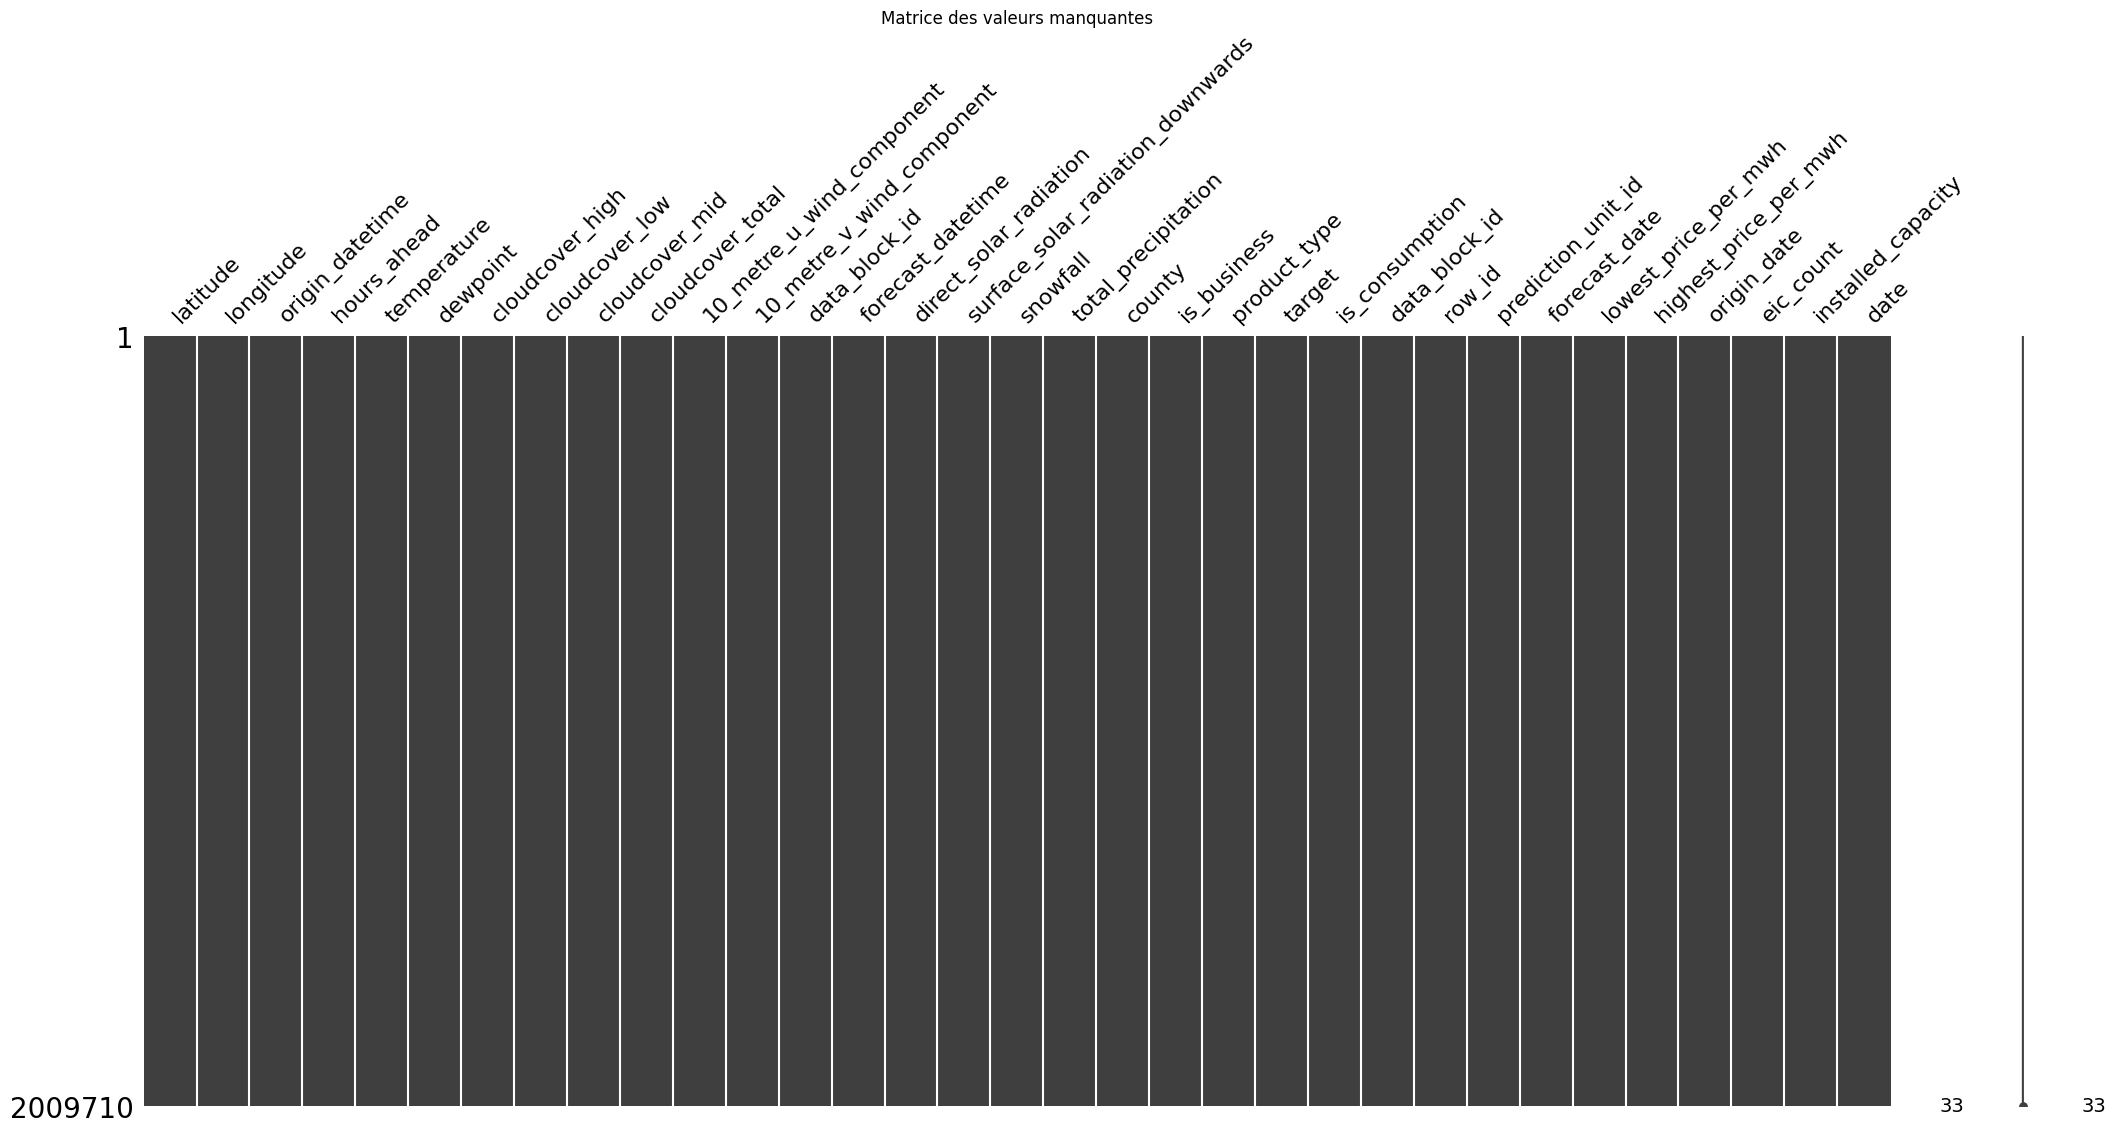

In [35]:
# Missing values
# Matrice des valeurs manquantes
plt.figure(figsize=(12, 6))
msno.matrix(df_train_forecast)
plt.title('Matrice des valeurs manquantes')
plt.show()


# 2 EDA

## 2.1 **Analyse univarié**
## 2.2 **Feature engeneering**
## 2.3 **Analyse de colinéarité**

In [26]:
df_train_forecast.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2009710 entries, 2021-09-03 00:00:00 to 2023-05-31 23:00:00
Data columns (total 33 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   latitude                           float64       
 1   longitude                          float64       
 2   origin_datetime                    datetime64[ns]
 3   hours_ahead                        int64         
 4   temperature                        float64       
 5   dewpoint                           float64       
 6   cloudcover_high                    float64       
 7   cloudcover_low                     float64       
 8   cloudcover_mid                     float64       
 9   cloudcover_total                   float64       
 10  10_metre_u_wind_component          float64       
 11  10_metre_v_wind_component          float64       
 12  data_block_id                      int64         
 13  forecast_datetime       

# 2.1 Analyse univarié

### Monthly production energy

Pour January 2022 la production moyenne est de 2.82430481582877
Pour January 2023 la production moyenne est de 4.858128247015166
Pour February 2022 la production moyenne est de 15.845479155411489
Pour February 2023 la production moyenne est de 17.742432730116178
Pour March 2022 la production moyenne est de 91.76743993578687
Pour March 2023 la production moyenne est de 71.86949078924842
Pour April 2022 la production moyenne est de 130.5580373873874
Pour April 2023 la production moyenne est de 220.91586209857462


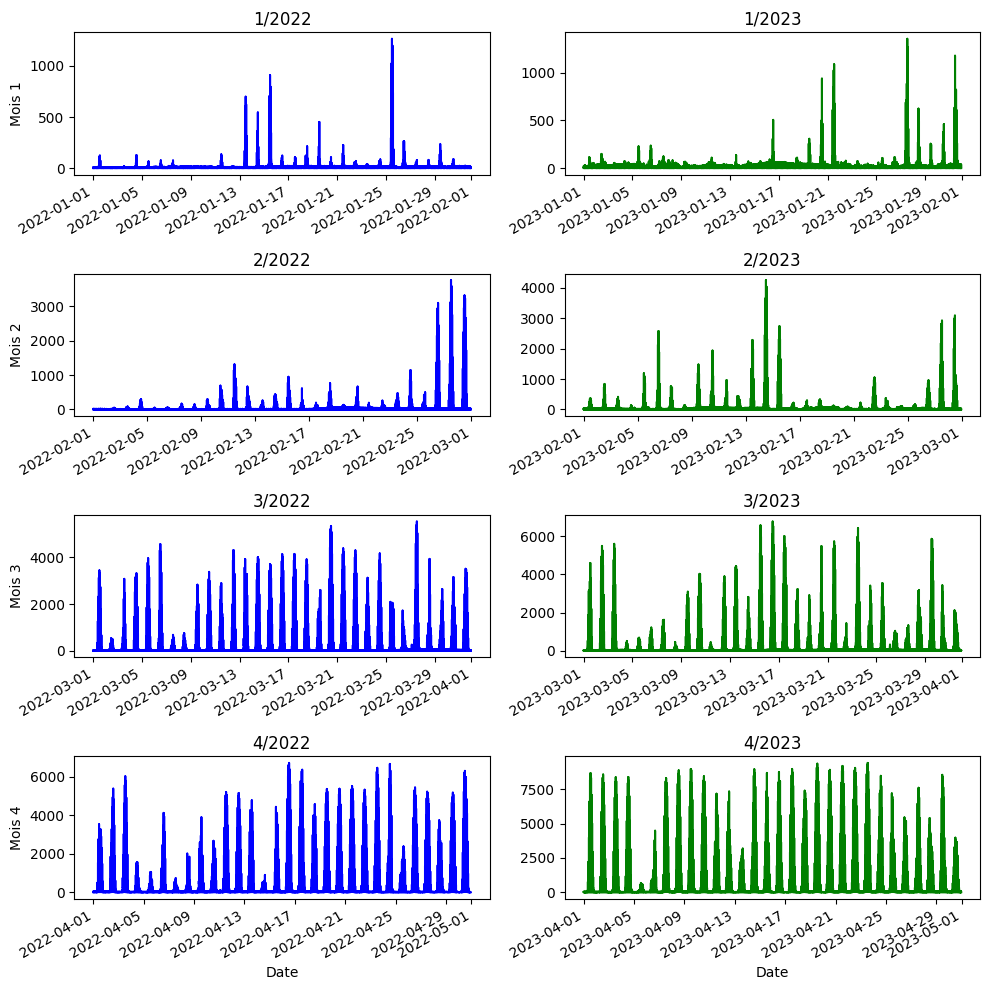

In [27]:
# Filtre les données pour les mois de septembre à décembre pour les années 2021, 2022 et 2023
months = np.arange(1,5)
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']
years = [2022, 2023]
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
colors = ['blue', 'green', 'red']

for i, month in enumerate(months):
    for j, year in enumerate(years):
        df = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month == month) & (df_train_forecast['origin_datetime'].dt.year == year) & (df_train_forecast['is_consumption'] == 0),'target']
                
        print(f"Pour {Months[month-1]} {year} la production moyenne est de",df.mean())

        ax = axs[i, j]
        if not df.empty:
            df.plot(ax=ax, y='target', x='date', title=f'{month}/{year}', color=colors[j])
            #ax.fill_between(df['datetime'], df['target'], color=colors[j], alpha=0.1)
        ax.set_xlabel('')
        ax.set_ylabel('')
        if j == 0:
            ax.set_ylabel(f'Mois {month}')
        if i == len(months) - 1:
            ax.set_xlabel('Date')
# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()


### Observations sur la Production d'Énergie Électrique via les Panneaux Solaires

#### Janvier 2022 et 2023
- **Production Moyenne**:
  - 2022: 2 Watts
  - 2023: 4 Watts
- **Observations**:
  - La production est très faible en janvier, ce qui est cohérent avec la faible intensité solaire hivernale.
  - Des pics de production dépassant les 500 watts apparaissent au milieu et à la fin du mois, suggérant une demande accrue pendant ces périodes.

#### Février 2022 et 2023
- **Production Moyenne**:
  - 2022: 15 Watts
  - 2023: 17 Watts
- **Observations**:
  - Une légère augmentation de la production par rapport à janvier, probablement due à l'allongement des jours et à une meilleure irradiation solaire.
  - Des pics de production dépassant les 1000 watts, souvent observés à mi-février et à la fin du mois, indiquent une utilisation accrue pendant ces périodes spécifiques.

#### Mars 2022 et 2023
- **Production Moyenne**:
  - 2022: 71 Watts
  - 2023: 71 Watts
- **Observations**:
  - Une augmentation significative de la production, probablement liée à l'amélioration des conditions météorologiques et à une meilleure exposition au soleil.
  - Des pics de production dépassant les 1000 watts, répartis tout au long du mois, montrent une demande régulière et accrue.

#### Avril 2022 et 2023
- **Production Moyenne**:
  - 2022: 130 Watts
  - 2023: 220 Watts
- **Observations**:
  - La production continue d'augmenter de manière significative, indiquant une bonne performance des panneaux solaires pendant cette période.
  - Des pics de production dépassant les 6000 watts, suggérant une utilisation intensive de l'énergie solaire, répartie tout au long du mois.

### Conclusion
- **Tendance Générale**: La production d'énergie solaire augmente de manière constante de janvier à avril, ce qui est cohérent avec l'amélioration des conditions météorologiques et l'augmentation de la durée d'ensoleillement.
- **Piques de Consommation**: Les pics de consommation, bien que élevés, semblent se produire régulièrement, ce qui pourrait indiquer une demande accrue pour certaines activités ou une utilisation spécifique de l'énergie pendant ces périodes.
- **Différence Année sur Année**: Une légère augmentation de la production entre 2022 et 2023 pourrait indiquer des améliorations dans l'efficacité des panneaux solaires ou des conditions météorologiques plus favorables en 2023.


Pour May 2022 la production moyenne est de 150.24820165302518
(49848,)
Pour May 2023 la production moyenne est de 346.87271692004504
(49728,)
Pour June 2022 la production moyenne est de 187.33999348439576
(48192,)
Pour June 2023 la production moyenne est de nan
(0,)
Pour July 2022 la production moyenne est de 177.42185553111761
(49104,)
Pour July 2023 la production moyenne est de nan
(0,)
Pour August 2022 la production moyenne est de 161.57480772677283
(49102,)
Pour August 2023 la production moyenne est de nan
(0,)


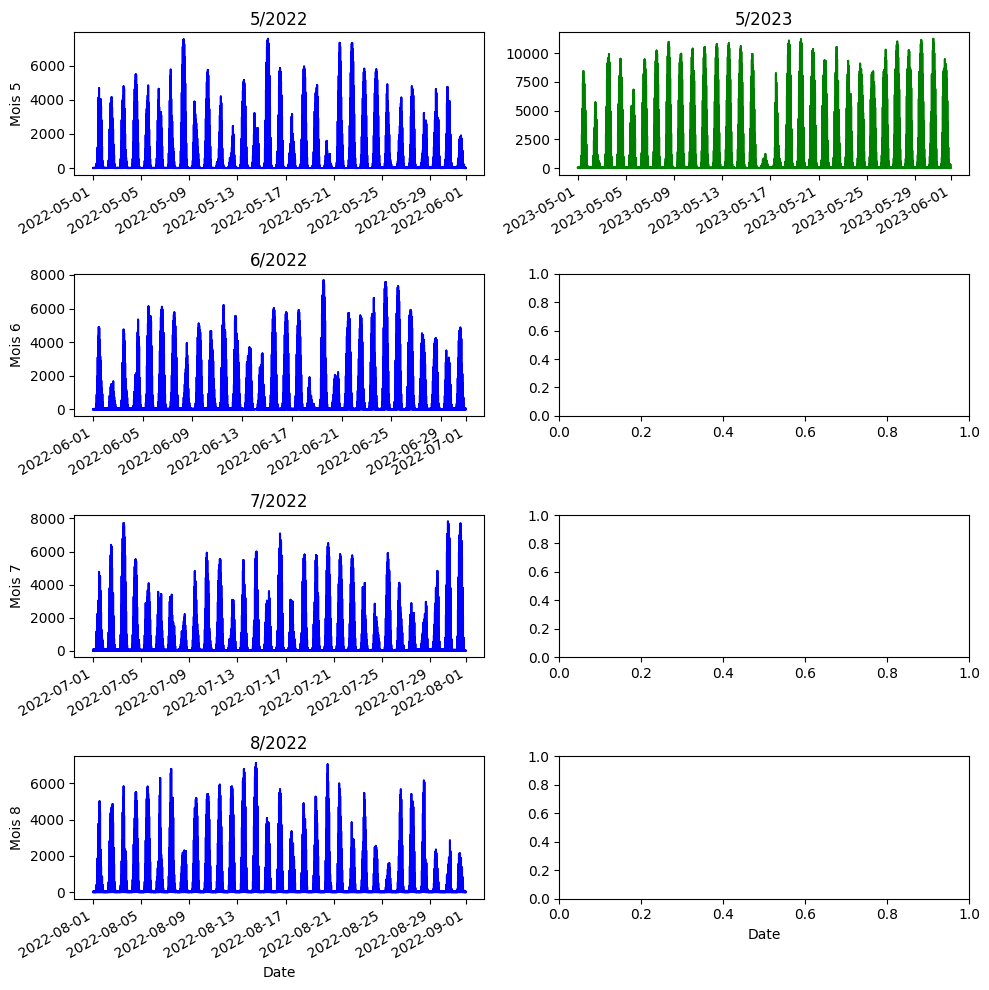

In [29]:
# For the period from September to December in 2022 and 2023, we observe similar seasonal patterns. 

months = np.arange(5,9)
years = [2022, 2023]
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
colors = ['blue', 'green', 'red']
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

for i, month in enumerate(months):
    for j, year in enumerate(years):
        df = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month == month) & (df_train_forecast['origin_datetime'].dt.year == year) & (df_train_forecast['is_consumption'] == 0),'target']
        print(f"Pour {Months[month-1]} {year} la production moyenne est de",df.mean())
        print(df.shape)
        ax = axs[i, j]
        if not df.empty:
            df.plot(ax=ax, y='target', x='date', title=f'{month}/{year}', color=colors[j])
            #ax.fill_between(df['datetime'], df['target'], color=colors[j], alpha=0.1)
        ax.set_xlabel('')
        ax.set_ylabel('')
        if j == 0:
            ax.set_ylabel(f'Mois {month}')
        if i == len(months) - 1:
            ax.set_xlabel('Date')
# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()


### Observations sur la Production Énergétique Mensuelle

#### Mai 2022 et 2023
- **production Moyenne**:
  - 2022: 150.25 kWh
  - 2023: 346.87 kWh
- **Observations**:
  - Une augmentation significative de la production moyenne en mai 2023 par rapport à mai 2022.
  - En 2022, des pics de production réguliers tout au long du mois.
  - En 2023, des pics de production plus fréquents et plus élevés, indiquant une demande accrue d'énergie.

#### Juin 2022 et 2023
- **production Moyenne**:
  - 2022: 187.34 kWh
  - 2023: Données non disponibles
- **Observations**:
  - La production moyenne en juin 2022 est relativement élevée avec des pics réguliers.
  - Les données de production pour juin 2023 ne sont pas disponibles.

#### Juillet 2022 et 2023
- **Production Moyenne**:
  - 2022: 177.42 kWh
  - 2023: Données non disponibles
- **Observations**:
  - La consommation moyenne en juillet 2022 est relativement élevée avec des pics réguliers.
  - Les données de consommation pour juillet 2023 ne sont pas disponibles.

#### Août 2022 et 2023
- **Consommation Moyenne**:
  - 2022: 161.57 kWh
  - 2023: Données non disponibles
- **Observations**:
  - La consommation moyenne en août 2022 est relativement élevée avec des pics réguliers.
  - Les données de consommation pour août 2023 ne sont pas disponibles.

### Conclusion
- **Tendance Générale**: La production énergétique montre une augmentation significative en mai 2023 par rapport à mai 2022, tandis que les données pour les mois de juin, juillet et août 2023 ne sont pas disponibles.
- **Piques de Consommation**: Les pics de production sont plus élevés et plus fréquents en mai 2023, suggérant une demande énergétique accrue.
- **Analyse Mensuelle**: Chaque mois présente des caractéristiques uniques de production, avec une augmentation notable en mai 2023.

Pour September 2021 la production moyenne est de 63.30377500487901
(40992,)
Pour September 2022 la production moyenne est de 110.06309045069722
(48192,)
Pour October 2021 la production moyenne est de 36.23374313382703
(46728,)
Pour October 2022 la production moyenne est de 41.522630051273644
(50544,)
Pour November 2021 la production moyenne est de 7.9936659391534395
(45360,)
Pour November 2022 la production moyenne est de 6.533777341231463
(49632,)
Pour December 2021 la production moyenne est de 1.43754572441483
(46824,)
Pour December 2022 la production moyenne est de 2.2372290160642567
(49800,)


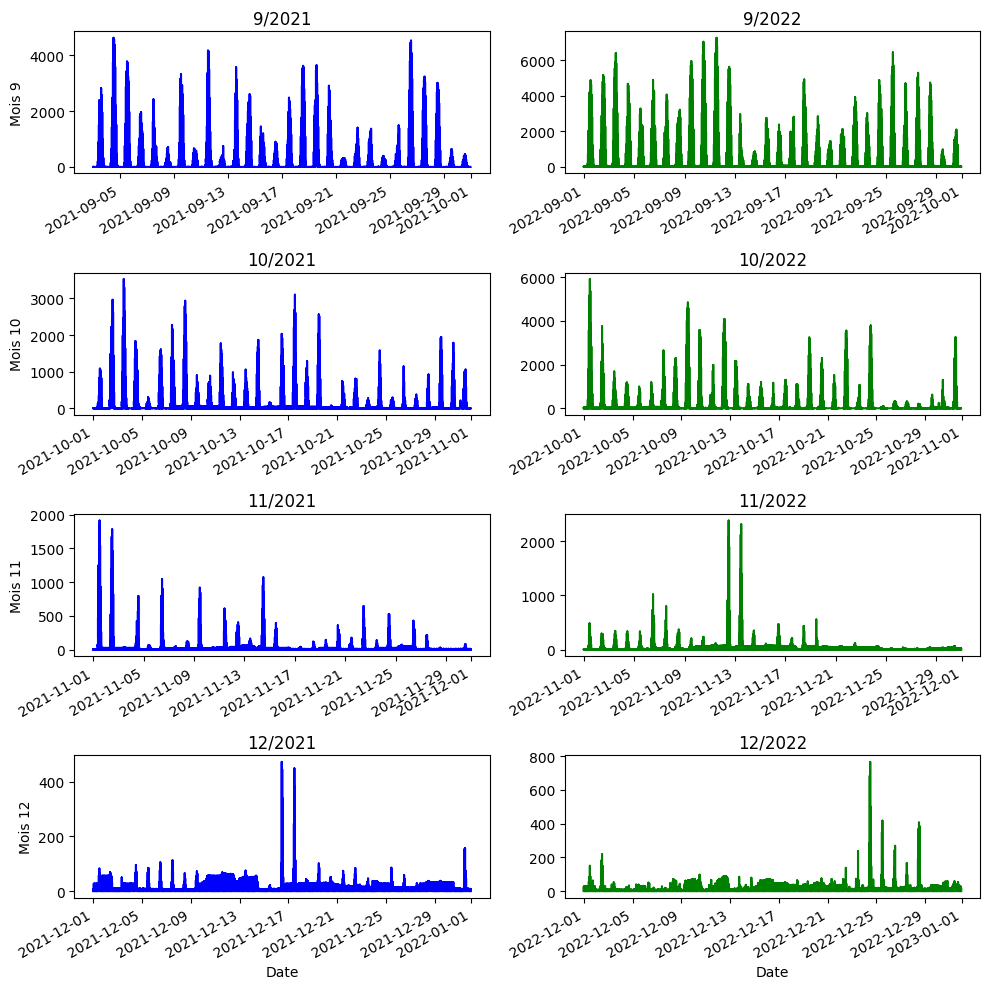

In [30]:
# For the period from September to December in 2021 and 2022, we observe similar seasonal patterns. 
# Filtre les données pour les mois de septembre à décembre pour les années 2021, 2022 et 2023
months = np.arange(9,13)
years = [2021, 2022]
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
colors = ['blue', 'green', 'red']
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

for i, month in enumerate(months):
    for j, year in enumerate(years):
        df = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month == month) & (df_train_forecast['origin_datetime'].dt.year == year) & (df_train_forecast['is_consumption'] == 0),'target']
        print(f"Pour {Months[month-1]} {year} la production moyenne est de",df.mean())
        print(df.shape)
        ax = axs[i, j]
        if not df.empty:
            df.plot(ax=ax, y='target', x='date', title=f'{month}/{year}', color=colors[j])
            #ax.fill_between(df['datetime'], df['target'], color=colors[j], alpha=0.1)
        ax.set_xlabel('')
        ax.set_ylabel('')
        if j == 0:
            ax.set_ylabel(f'Mois {month}')
        if i == len(months) - 1:
            ax.set_xlabel('Date')
# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()


### Observations sur la Production Énergétique Mensuelle

#### Septembre 2021 et 2022
- **Production Moyenne**:
  - 2021: 63.30 kWh
  - 2022: 110.06 kWh
- **Observations**:
  - Une augmentation notable de la production moyenne en septembre 2022 par rapport à septembre 2021.
  - En 2021, des pics de production réguliers tout au long du mois.
  - En 2022, des pics de production plus fréquents et plus élevés, indiquant une demande accrue d'énergie.

#### Octobre 2021 et 2022
- **Production Moyenne**:
  - 2021: 35.99 kWh
  - 2022: 41.24 kWh
- **Observations**:
  - Une légère augmentation de la production moyenne en octobre 2022 par rapport à octobre 2021.
  - En 2021, des pics de production variés tout au long du mois.
  - En 2022, des pics de production plus fréquents, mais d'intensité similaire à ceux de 2021.

#### Novembre 2021 et 2022
- **Production Moyenne**:
  - 2021: 7.99 kWh
  - 2022: 6.53 kWh
- **Observations**:
  - Une légère diminution de la production moyenne en novembre 2022 par rapport à novembre 2021.
  - En 2021, des pics de production sont présents mais moins fréquents.
  - En 2022, une tendance similaire avec des pics moins élevés, indiquant une baisse globale de la production énergétique.

#### Décembre 2021 et 2022
- **Production Moyenne**:
  - 2021: 1.44 kWh
  - 2022: 2.24 kWh
- **Observations**:
  - Une augmentation de la production moyenne en décembre 2022 par rapport à décembre 2021.
  - En 2021, des pics de production faibles et sporadiques tout au long du mois.
  - En 2022, des pics légèrement plus élevés mais toujours sporadiques, indiquant une légère hausse de la demande énergétique.

### Conclusion
- **Tendance Générale**: La production énergétique montre des variations significatives entre les différentes années et les mois, avec des augmentations notables en septembre et décembre.
- **Piques de Consommation**: Les pics de consommation sont plus fréquents et plus élevés en 2022 par rapport à 2021, suggérant une demande énergétique accrue.
- **Analyse Mensuelle**: Chaque mois présente des caractéristiques uniques de production, avec une augmentation globale de la production en septembre et décembre, et une légère baisse en novembre.


### Monthly consumption energy

Pour January 2022 la consommation moyenne est de 521.5431451178032
Pour January 2023 la consommation moyenne est de 645.1559315303323
Pour February 2022 la consommation moyenne est de 516.295188074014
Pour February 2023 la consommation moyenne est de 651.9238598525469
Pour March 2022 la consommation moyenne est de 441.4693673996608
Pour March 2023 la consommation moyenne est de 592.7245499204975
Pour April 2022 la consommation moyenne est de 384.7432782350532
Pour April 2023 la consommation moyenne est de 442.0482401682981


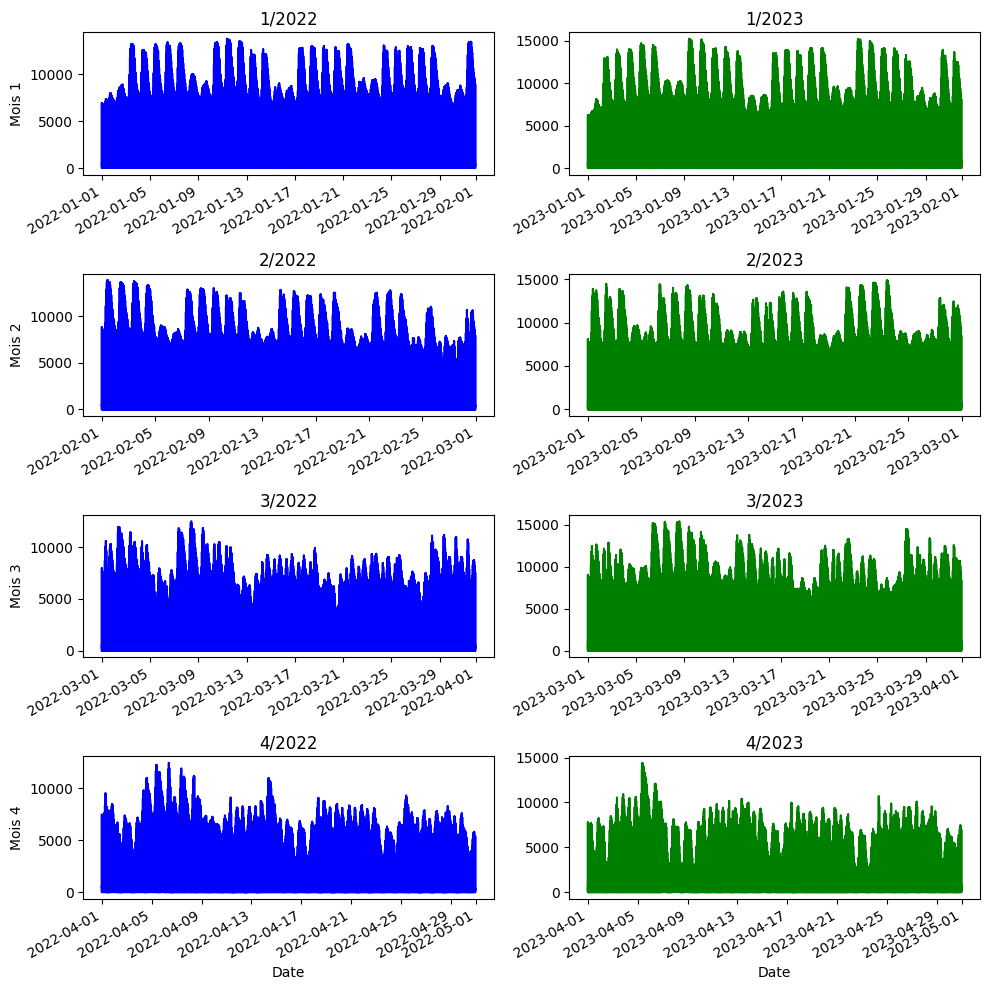

In [31]:
# Filtre les données pour les mois de septembre à décembre pour les années 2021, 2022 et 2023
months = np.arange(1,5)
years = [2022, 2023]
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
colors = ['blue', 'green', 'red']
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

for i, month in enumerate(months):
    for j, year in enumerate(years):
        df = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month == month) & (df_train_forecast['origin_datetime'].dt.year == year) & (df_train_forecast['is_consumption'] == 1),'target']
        print(f"Pour {Months[month-1]} {year} la consommation moyenne est de",df.mean())
        ax = axs[i, j]
        if not df.empty:
            df.plot(ax=ax, y='target', x='date', title=f'{month}/{year}', color=colors[j])
            #ax.fill_between(df['datetime'], df['target'], color=colors[j], alpha=0.1)
        ax.set_xlabel('')
        ax.set_ylabel('')
        if j == 0:
            ax.set_ylabel(f'Mois {month}')
        if i == len(months) - 1:
            ax.set_xlabel('Date')
# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()

### Observations sur la Consommation Énergétique Mensuelle

#### Janvier 2022 et 2023
- **Consommation Moyenne**:
  - 2022: 521.54 kWh
  - 2023: 645.16 kWh
- **Observations**:
  - Une augmentation notable de la consommation moyenne en janvier 2023 par rapport à janvier 2022.
  - Des pics de consommation réguliers et relativement élevés tout au long du mois pour les deux années.
  - La consommation semble plus constante et légèrement plus élevée en 2023.

#### Février 2022 et 2023
- **Consommation Moyenne**:
  - 2022: 516.30 kWh
  - 2023: 651.92 kWh
- **Observations**:
  - Une augmentation significative de la consommation moyenne en février 2023 par rapport à février 2022.
  - Des pics de consommation similaires en fréquence mais plus élevés en 2023.
  - La consommation reste élevée et constante tout au long du mois en 2023.

#### Mars 2022 et 2023
- **Consommation Moyenne**:
  - 2022: 441.71 kWh
  - 2023: 593.08 kWh
- **Observations**:
  - Une augmentation de la consommation moyenne en mars 2023 par rapport à mars 2022.
  - Des pics de consommation plus élevés et fréquents en 2023.
  - Une consommation plus variable en 2022 comparée à une consommation plus stable en 2023.

#### Avril 2022 et 2023
- **Consommation Moyenne**:
  - 2022: 384.74 kWh
  - 2023: 442.05 kWh
- **Observations**:
  - Une augmentation de la consommation moyenne en avril 2023 par rapport à avril 2022.
  - Des pics de consommation réguliers mais légèrement plus élevés en 2023.
  - Une tendance à une consommation plus élevée en 2023 tout au long du mois.

### Conclusion
- **Tendance Générale**: La consommation énergétique montre une augmentation significative de 2022 à 2023 pour les mois de janvier à avril.
- **Piques de Consommation**: Les pics de consommation sont plus élevés et plus fréquents en 2023, suggérant une demande énergétique accrue.
- **Analyse Mensuelle**: Chaque mois présente une augmentation de la consommation en 2023 par rapport à 2022, avec une tendance à une consommation plus stable et plus élevée en 2023.


Pour September 2021 la consommation moyenne est de 367.6111481996487
(40992,)
Pour September 2022 la consommation moyenne est de 400.6753124169987
(48192,)
Pour October 2021 la consommation moyenne est de 400.4904855152686
(46728,)
Pour October 2022 la consommation moyenne est de 462.0182506194914
(50544,)
Pour November 2021 la consommation moyenne est de 462.99353979276896
(45360,)
Pour November 2022 la consommation moyenne est de 548.4960630641522
(49632,)
Pour December 2021 la consommation moyenne est de 507.13006069536993
(46824,)
Pour December 2022 la consommation moyenne est de 605.0669500803212
(49800,)


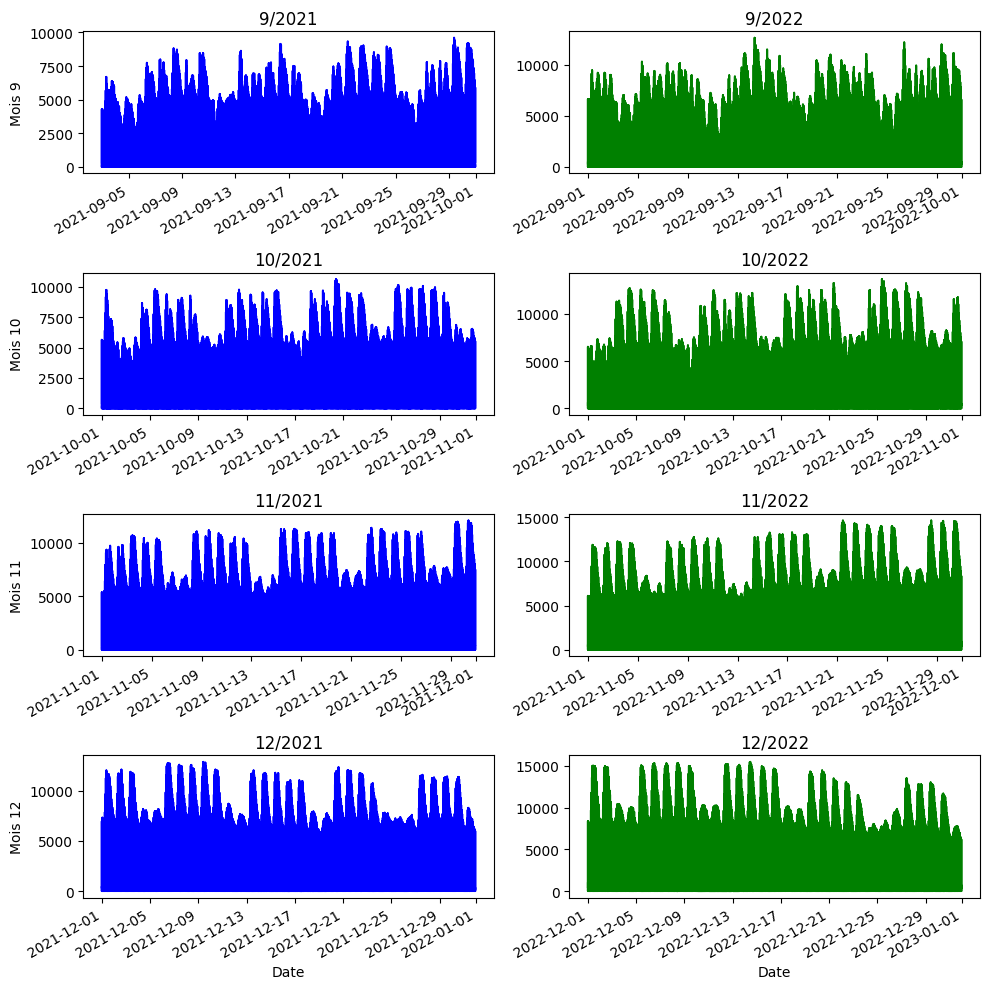

In [32]:
# For the period from September to December in 2021 and 2022, we observe similar seasonal patterns. 
# Filtre les données pour les mois de septembre à décembre pour les années 2021, 2022 et 2023
months = np.arange(9,13)
years = [2021, 2022]
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
colors = ['blue', 'green', 'red']
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

for i, month in enumerate(months):
    for j, year in enumerate(years):
        df = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month == month) & (df_train_forecast['origin_datetime'].dt.year == year) & (df_train_forecast['is_consumption'] == 1),'target']
        print(f"Pour {Months[month-1]} {year} la consommation moyenne est de",df.mean())
        print(df.shape)
        ax = axs[i, j]
        if not df.empty:
            df.plot(ax=ax, y='target', x='date', title=f'{month}/{year}', color=colors[j])
            #ax.fill_between(df['datetime'], df['target'], color=colors[j], alpha=0.1)
        ax.set_xlabel('')
        ax.set_ylabel('')
        if j == 0:
            ax.set_ylabel(f'Mois {month}')
        if i == len(months) - 1:
            ax.set_xlabel('Date')
# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()

### Observations sur la Consommation Énergétique Mensuelle

#### Septembre 2021 et 2022
- **Consommation Moyenne**:
  - 2021: 367.61 kWh
  - 2022: 400.68 kWh
- **Observations**:
  - Une augmentation de la consommation moyenne en septembre 2022 par rapport à septembre 2021.
  - En 2021, des pics de consommation réguliers tout au long du mois.
  - En 2022, des pics de consommation plus élevés, indiquant une demande accrue d'énergie.

#### Octobre 2021 et 2022
- **Consommation Moyenne**:
  - 2021: 400.74 kWh
  - 2022: 462.30 kWh
- **Observations**:
  - Une augmentation significative de la consommation moyenne en octobre 2022 par rapport à octobre 2021.
  - Des pics de consommation réguliers tout au long du mois pour les deux années, mais plus élevés en 2022.

#### Novembre 2021 et 2022
- **Consommation Moyenne**:
  - 2021: 462.99 kWh
  - 2022: 548.50 kWh
- **Observations**:
  - Une augmentation notable de la consommation moyenne en novembre 2022 par rapport à novembre 2021.
  - Des pics de consommation réguliers tout au long du mois pour les deux années, mais plus élevés en 2022.

#### Décembre 2021 et 2022
- **Consommation Moyenne**:
  - 2021: 507.13 kWh
  - 2022: 605.07 kWh
- **Observations**:
  - Une augmentation significative de la consommation moyenne en décembre 2022 par rapport à décembre 2021.
  - Des pics de consommation réguliers tout au long du mois pour les deux années, mais plus élevés en 2022.

### Conclusion
- **Tendance Générale**: La consommation énergétique montre une augmentation significative de 2021 à 2022 pour les mois de septembre à décembre.
- **Piques de Consommation**: Les pics de consommation sont plus élevés en 2022, suggérant une demande énergétique accrue.
- **Analyse Mensuelle**: Chaque mois présente une augmentation de la consommation en 2022 par rapport à 2021, avec une tendance à une consommation plus stable et plus élevée en 2022.


## Monthly consumption and production energy 

Pour May 2022 la production-consommation moyenne est de 252.59033179866796
Pour May 2023 la production-consommation moyenne est de 363.78647482303734
Pour June 2022 la production-consommation moyenne est de 247.05935683308428
Pour June 2023 la production-consommation moyenne est de nan
Pour July 2022 la production-consommation moyenne est de 247.0795112007169
Pour July 2023 la production-consommation moyenne est de nan
Pour August 2022 la production-consommation moyenne est de 271.2485408834491
Pour August 2023 la production-consommation moyenne est de nan


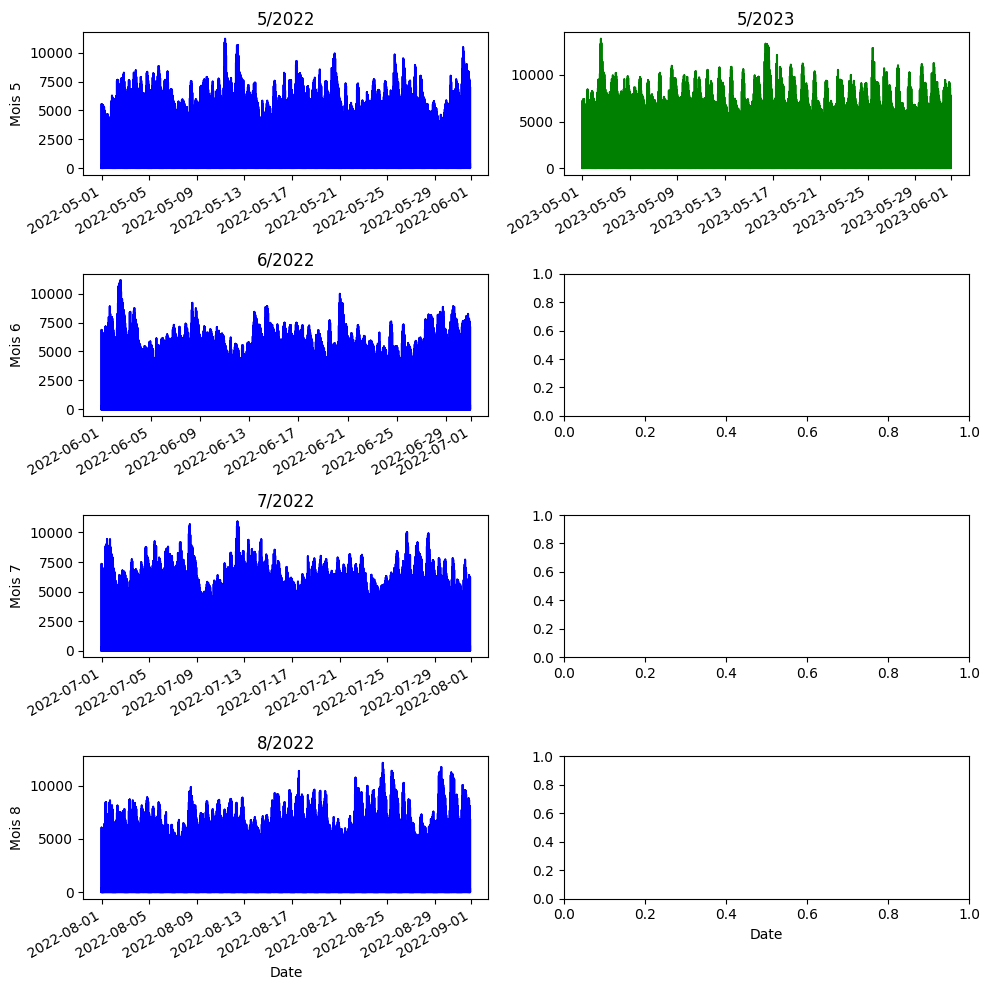

In [33]:
# Filtre les données pour les mois de septembre à décembre pour les années 2021, 2022 et 2023
months = np.arange(5,9)
years = [2022, 2023]
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
colors = ['blue', 'green', 'red']
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

for i, month in enumerate(months):
    for j, year in enumerate(years):
        df = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month == month) & (df_train_forecast['origin_datetime'].dt.year == year),'target']
        print(f"Pour {Months[month-1]} {year} la production-consommation moyenne est de",df.mean())
        ax = axs[i, j]
        if not df.empty:
            df.plot(ax=ax, y='target', x='date', title=f'{month}/{year}', color=colors[j])
            #ax.fill_between(df['datetime'], df['target'], color=colors[j], alpha=0.1)
        ax.set_xlabel('')
        ax.set_ylabel('')
        if j == 0:
            ax.set_ylabel(f'Mois {month}')
        if i == len(months) - 1:
            ax.set_xlabel('Date')
# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()


Pour September 2021 la production-consommation moyenne est de 215.45746160226386
Pour September 2022 la production-consommation moyenne est de 255.3692014338479
Pour October 2021 la production-consommation moyenne est de 218.3621143245478
Pour October 2022 la production-consommation moyenne est de 251.77044033538252
Pour November 2021 la production-consommation moyenne est de 235.49360286596118
Pour November 2022 la production-consommation moyenne est de 277.51492020269177
Pour December 2021 la production-consommation moyenne est de 254.2838032098923
Pour December 2022 la production-consommation moyenne est de 303.65208954819275


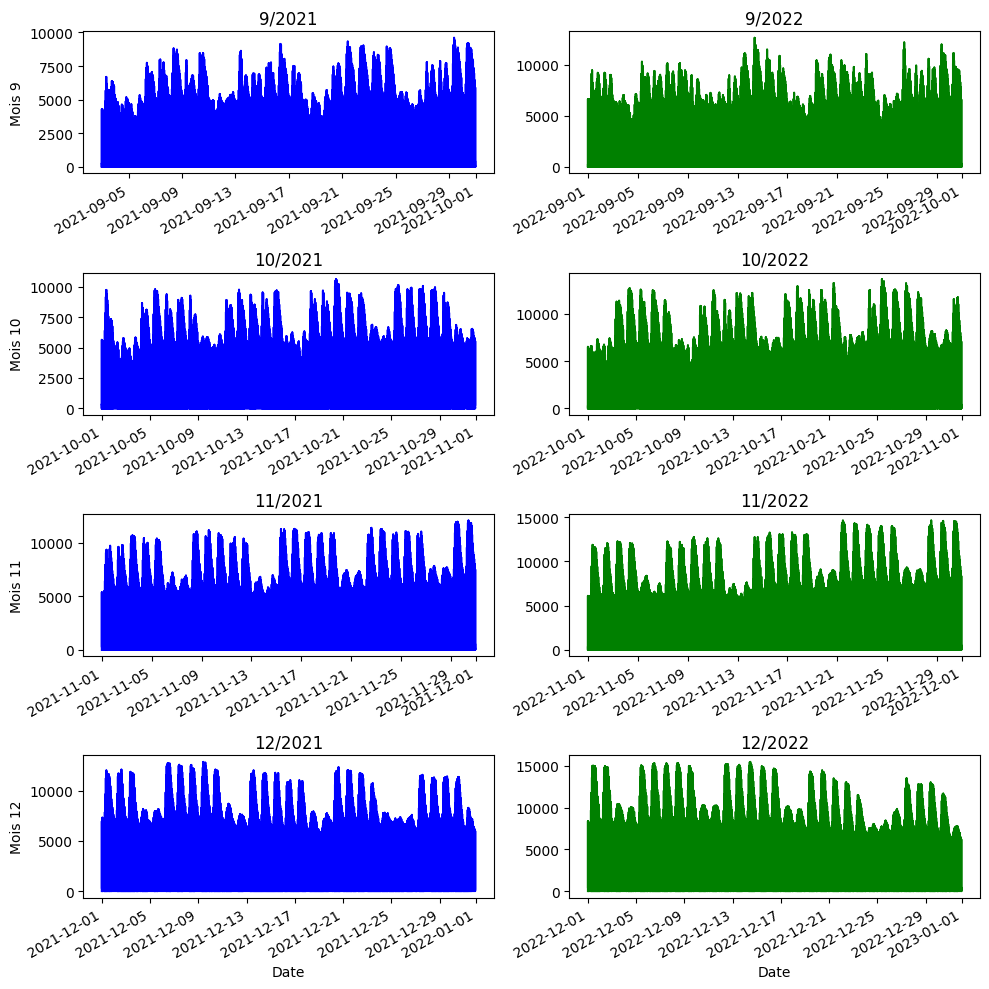

In [34]:
months = np.arange(9,13)
years = [2021, 2022]
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
colors = ['blue', 'green', 'red']
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

for i, month in enumerate(months):
    for j, year in enumerate(years):
        df = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month == month) & (df_train_forecast['origin_datetime'].dt.year == year),'target']
        print(f"Pour {Months[month-1]} {year} la production-consommation moyenne est de",df.mean())

        ax = axs[i, j]
        if not df.empty:
            df.plot(ax=ax, y='target', x='date', title=f'{month}/{year}', color=colors[j])
        ax.set_xlabel('')
        ax.set_ylabel('')
        if j == 0:
            ax.set_ylabel(f'Mois {month}')
        if i == len(months) - 1:
            ax.set_xlabel('Date')
# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()


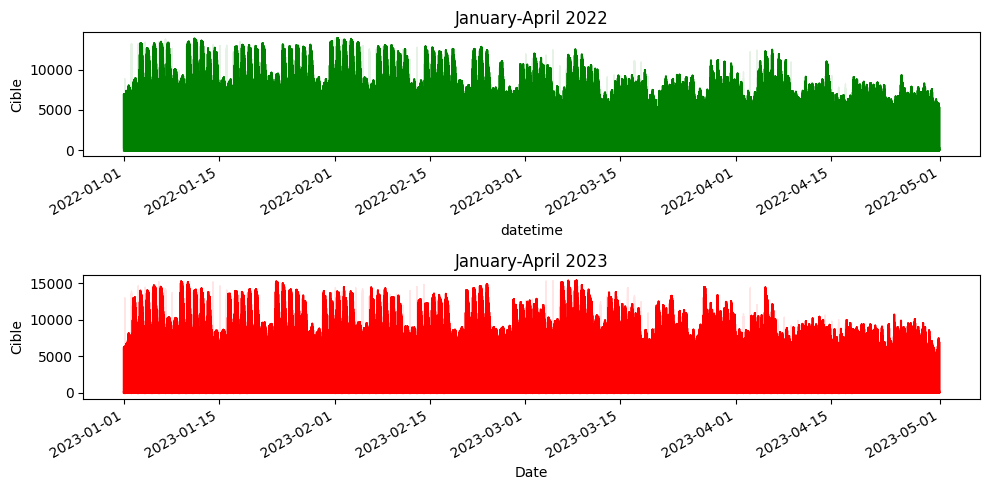

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_train_forecast is your DataFrame
#df_train_forecast['datetime'] = pd.to_datetime(df_train_forecast['origin_datetime'])
            #ax.fill_between(df['datetime'], df['target'], color=colors[j], alpha=0.1)

# Filtre les données pour les années  2022 et 2023
df_january_april_2022 = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month >=1)&(df_train_forecast['origin_datetime'].dt.month <= 4)& (df_train_forecast['origin_datetime'].dt.year == 2022)]
df_january_april__2023 = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month >=1)&(df_train_forecast['origin_datetime'].dt.month <= 4)& (df_train_forecast['origin_datetime'].dt.year == 2023)]

fig, axs = plt.subplots(2, 1, figsize=(10, 5))

# Tracer les données pour chaque année sur des sous-graphiques séparés avec des bandes de couleur

df_january_april_2022.target.plot(ax=axs[0], x='origin_datetime', title='January-April 2022', color='green')
axs[0].fill_between(df_january_april_2022['origin_datetime'], df_january_april_2022['target'], color='green', alpha=0.1)

df_january_april__2023.target.plot(ax=axs[1],  x='origin_datetime', title='January-April 2023', color='red')
axs[1].fill_between(df_january_april__2023['origin_datetime'], df_january_april__2023['target'], color='red', alpha=0.1)

# Ajouter des labels
axs[1].set_xlabel('Date')
for ax in axs:
    ax.set_ylabel('Cible')

plt.tight_layout()

plt.show()



In [36]:
print(f'max comsumption january to april {df_january_april_2022.target.max()}, mean consumption january to april {df_january_april_2022.target.mean()}, low consumption january to april {df_january_april_2022.target.min()}' )

max comsumption january to april 13896.422, mean consumption january to april 263.0737245036282, low consumption january to april 0.0


- We can see the seasonality every three months. The consumption varies from 0 to 13,896.

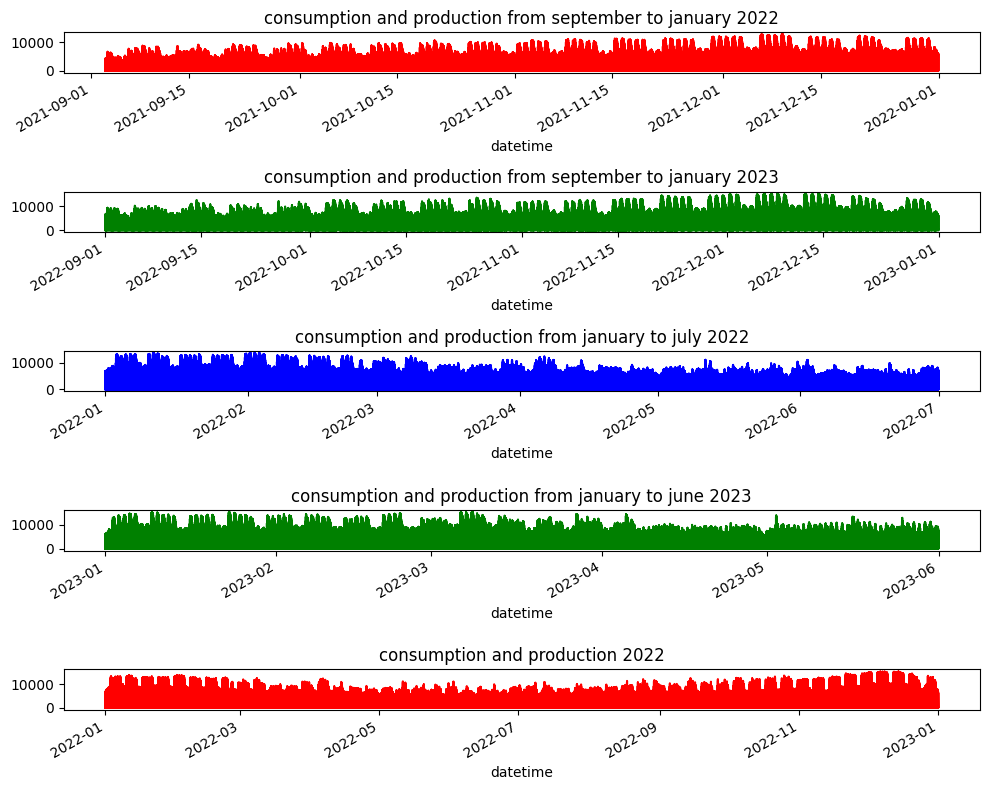

In [37]:
fig, ax = plt.subplots(5,1,figsize=(10,8))
df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.year == 2021),'target'].plot(ax=ax[0],color='red',title = 'consumption and production from september to january 2022')
df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.year == 2022)&(df_train_forecast['origin_datetime'].dt.month >= 9)&(df_train_forecast['origin_datetime'].dt.month <= 12),'target'].plot(ax=ax[1],color='green', title = 'consumption and production from september to january 2023')
df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.year == 2022)&(df_train_forecast['origin_datetime'].dt.month >= 1)&(df_train_forecast['origin_datetime'].dt.month <= 6),'target'].plot(ax=ax[2],color='blue', title = 'consumption and production from january to july 2022')
df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.year == 2023),'target'].plot(ax=ax[3],color='green', title = 'consumption and production from january to june 2023')
df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.year == 2022),'target'].plot(ax=ax[4], color='red',title = 'consumption and production 2022')

plt.tight_layout()
plt.show()

In [38]:
df_train_forecast.head(7)

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,...,data_block_id,row_id,prediction_unit_id,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,eic_count,installed_capacity,date
datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-03,58.2,23.7,2021-09-02 02:00:00,5,13.476221,6.160547,0.0,0.238205,0.304855,0.367310,...,2.0,5856.0,0.0,2021-09-02,45.62,46.29,2021-09-01,108.0,952.89,2021-09-01
2021-09-03,58.2,24.2,2021-09-02 02:00:00,5,11.961450,7.848840,0.0,0.025429,0.007751,0.029190,...,2.0,5857.0,0.0,2021-09-02,45.62,46.29,2021-09-01,108.0,952.89,2021-09-01
2021-09-03,58.2,24.7,2021-09-02 02:00:00,5,10.000146,6.802637,0.0,0.000954,0.000412,0.001251,...,2.0,5858.0,1.0,2021-09-02,45.62,46.29,2021-09-01,17.0,166.40,2021-09-01
2021-09-03,58.2,25.2,2021-09-02 02:00:00,5,8.649683,6.022607,0.0,0.002556,0.000214,0.002609,...,2.0,5859.0,1.0,2021-09-02,45.62,46.29,2021-09-01,17.0,166.40,2021-09-01
2021-09-03,58.2,25.7,2021-09-02 02:00:00,5,8.485620,5.985437,0.0,0.008598,0.000153,0.008652,...,2.0,5860.0,2.0,2021-09-02,45.62,46.29,2021-09-01,688.0,7207.88,2021-09-01
2021-09-03,58.2,26.2,2021-09-02 02:00:00,5,9.599756,6.760217,0.0,0.022346,0.000839,0.022461,...,2.0,5861.0,2.0,2021-09-02,45.62,46.29,2021-09-01,688.0,7207.88,2021-09-01
2021-09-03,58.2,26.7,2021-09-02 02:00:00,5,8.753809,6.130945,0.0,0.062500,0.006287,0.063446,...,2.0,5862.0,3.0,2021-09-02,45.62,46.29,2021-09-01,5.0,400.00,2021-09-01


In [39]:

cols = df_train_forecast.drop(columns=[ 'latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns

df_train_forecast[cols].describe()

,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,is_business,product_type,target,is_consumption,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity
count,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2009710.0,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06
mean,5.649384e+00,2.298356e+00,4.068336e-01,4.140119e-01,3.583144e-01,6.833568e-01,1.420097e+00,1.050718e+00,1.529539e+02,1.113298e+02,2.510803e-05,7.883715e-05,5.366973e-01,1.898971e+00,2.753058e+02,0.5,9.556074e+01,1.084196e+02,7.342623e+01,1.452344e+03
std,7.834997e+00,7.152849e+00,4.459749e-01,4.352261e-01,4.183819e-01,3.988468e-01,3.979913e+00,4.205521e+00,2.569471e+02,1.867504e+02,1.223223e-04,2.752820e-04,4.986516e-01,1.082261e+00,9.105864e+02,0.5,4.757702e+01,5.474951e+01,1.441296e+02,2.423212e+03
min,-2.749940e+01,-2.968357e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.640865e+01,-2.211612e+01,-7.733333e-01,-3.258333e-01,-3.814697e-06,-1.529098e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.0,2.810000e+01,3.400000e+01,5.000000e+00,6.000000e+00
25%,3.701416e-01,-2.339331e+00,0.000000e+00,3.051758e-05,0.000000e+00,2.740173e-01,-1.255646e+00,-1.648080e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.800000e-01,0.0,6.000000e+01,6.769000e+01,1.400000e+01,3.237000e+02
50%,4.852686e+00,1.743799e+00,1.196442e-01,1.889954e-01,1.060797e-01,9.749445e-01,1.580403e+00,1.243975e+00,0.000000e+00,6.322222e-01,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,3.130000e+01,1.0,8.600000e+01,9.400000e+01,3.200000e+01,6.470800e+02
75%,1.132534e+01,7.382639e+00,9.841614e-01,9.973755e-01,8.913879e-01,9.999999e-01,3.978495e+00,3.813097e+00,2.231897e+02,1.487806e+02,0.000000e+00,2.647305e-05,1.000000e+00,3.000000e+00,1.808800e+02,1.0,1.097400e+02,1.330000e+02,7.000000e+01,1.567150e+03
max,3.124551e+01,2.267642e+01,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,2.203584e+01,1.810218e+01,9.544222e+02,8.319411e+02,4.832983e-03,1.629448e-02,1.000000e+00,3.000000e+00,1.548027e+04,1.0,2.500000e+02,3.050000e+02,1.517000e+03,1.931431e+04


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

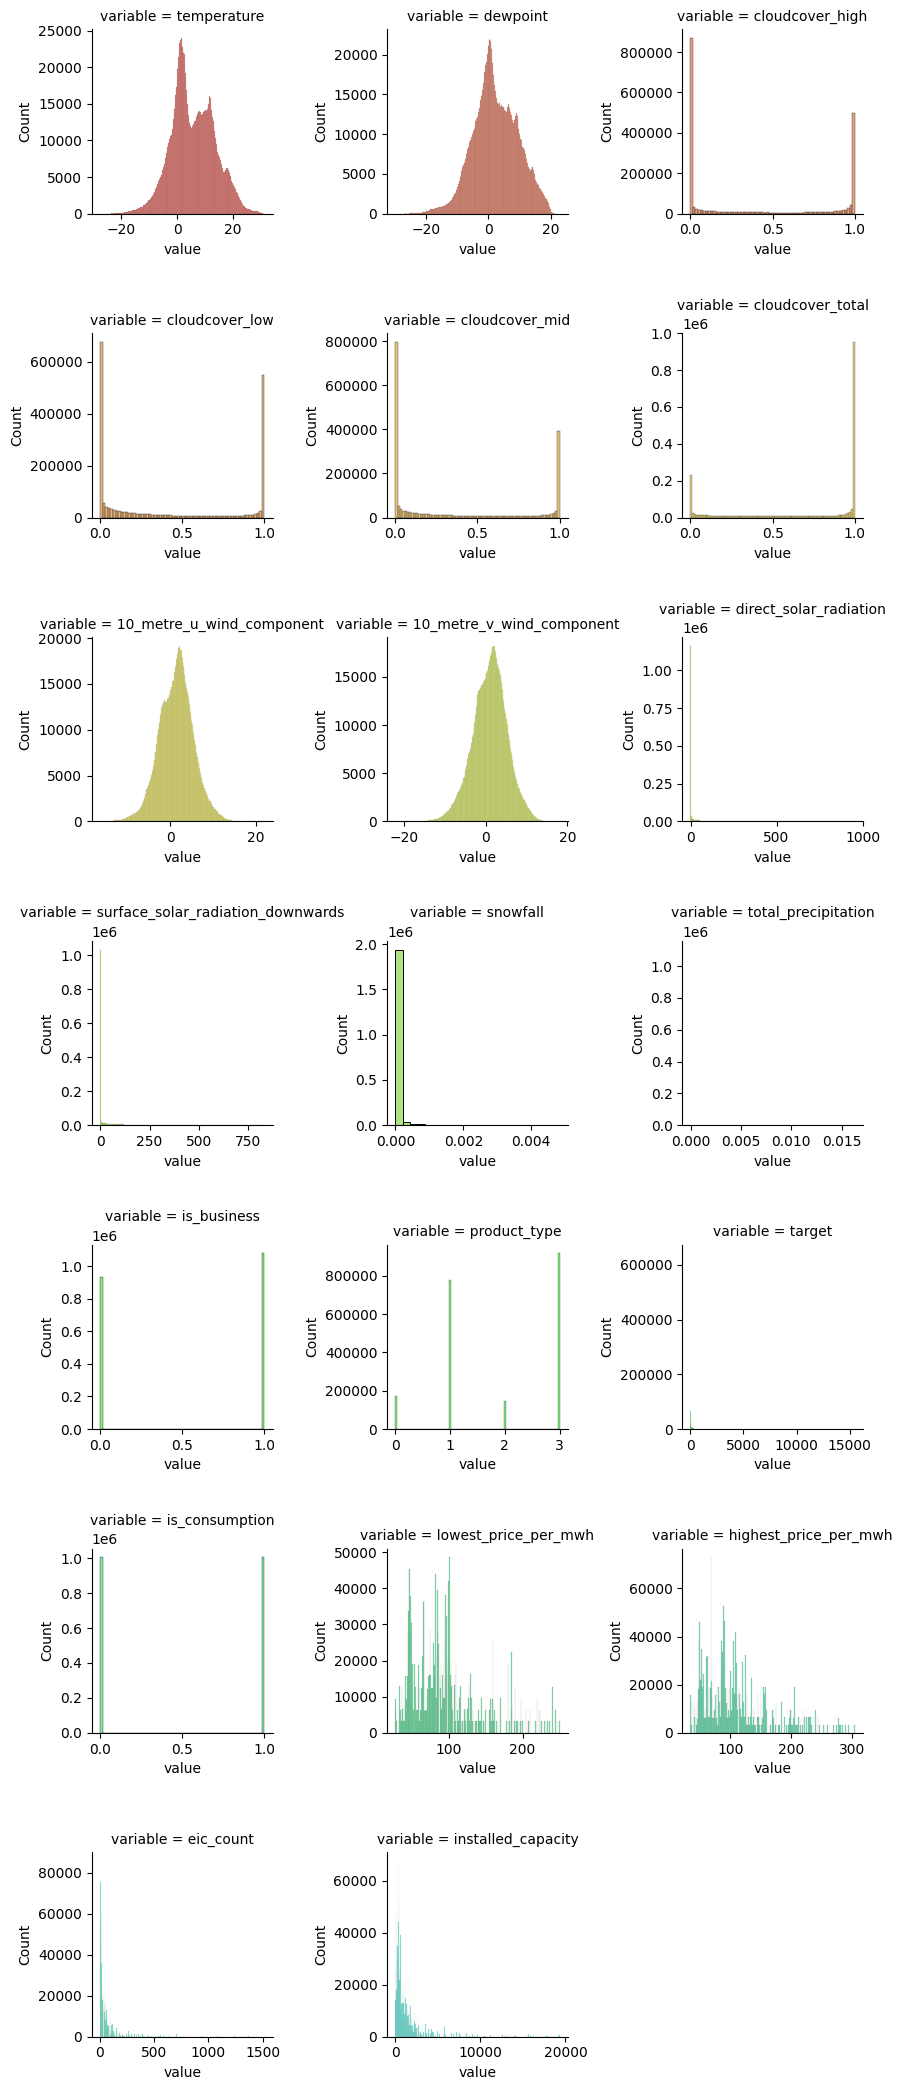

In [40]:
#What type of distribution law does each variable follow?

cols = df_train_forecast.drop(columns=[ 'latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns

# Conversion des infinis en NaN
df = df_train_forecast[cols].replace([np.inf, -np.inf], np.nan)

#cols = df_train_forecast.select_dtypes(include=np.number).columns
f = pd.melt(df, value_vars = cols)
g = sns.FacetGrid(f, col = 'variable',col_wrap=3, sharex=False, sharey=False)


for ax, col, color in zip(g.axes.flat,cols , sns.color_palette("hls", 40)):
    sns.histplot(data=f[f['variable'] == col], x='value', ax=ax, color=color)

# Ajustement des espacements
g.fig.tight_layout(w_pad=2, h_pad=3)

# Affichage du graphique
plt.show()

### Interprétation des Graphiques

#### Température
- La température semble suivre une distribution normale avec une moyenne autour de 0.
- **Distribution en forme de cloche** : Indique que les températures sont symétriquement distribuées autour de la moyenne.
- Cela est typique d'une distribution normale.

#### Point de Rosée
- **Distribution en forme de cloche**, similaire à la température.
- Indique une distribution symétrique autour de la moyenne.

#### Couverture Nuageuse
- **Cloudcover_low, Cloudcover_mid, Cloudcover_high, Cloudcover_total** :
  - Distributions fortement asymétriques avec des pics à 0 et 1.
  - Cela indique que la couverture nuageuse est souvent soit totalement absente (0) soit complète (1), avec peu de valeurs intermédiaires.

#### Composantes du Vent
- **10_metre_u_wind_component, 10_metre_v_wind_component** :
  - Distributions symétriques centrées autour de 0.
  - Suggère que les composantes du vent suivent une distribution normale, avec des valeurs positives et négatives autour de la moyenne.

#### Rayonnement Solaire
- **Direct_solar_radiation, Surface_solar_radiation_downwards** :
  - Distributions asymétriques avec des pics à de faibles valeurs.
  - Indique que la plupart des valeurs de rayonnement solaire sont faibles, avec quelques valeurs plus élevées.

#### Précipitations Totales
- Distribution fortement asymétrique avec la plupart des valeurs proches de 0.
- Indique que les précipitations sont souvent nulles ou très faibles, avec quelques occurrences de fortes précipitations.

### Interprétation des Résultats

#### Rayonnement Solaire de Surface Vers le Bas
- **Distribution** : La distribution est extrêmement asymétrique, avec la plupart des valeurs très proches de zéro et quelques valeurs beaucoup plus élevées.
- **Interprétation** : Cela suggère que la plupart du temps, le rayonnement solaire de surface est faible, mais il y a des occasions où il atteint des niveaux très élevés.

#### Chutes de Neige
- **Distribution** : La distribution montre que presque toutes les valeurs de chute de neige sont très proches de zéro, avec quelques valeurs légèrement plus élevées.
- **Interprétation** : Les chutes de neige sont très rares dans l'ensemble de données, avec la majorité des jours ayant peu ou pas de neige.

#### Précipitations Totales
- **Distribution** : Distribution extrêmement asymétrique, similaire au rayonnement solaire, avec la plupart des valeurs proches de zéro et quelques valeurs beaucoup plus élevées.
- **Interprétation** : La plupart du temps, les précipitations totales sont faibles, mais il y a des événements occasionnels de fortes précipitations.

#### Est-ce une Entreprise ?
- **Distribution** : Distribution binaire avec des valeurs principalement à 0 et 1.
- **Interprétation** : Cela indique que cette variable est probablement une variable catégorielle indiquant si l'entité est une entreprise ou non.

#### Type de Produit
- **Distribution** : Les valeurs sont principalement réparties entre les catégories 0, 1, 2 et 3.
- **Interprétation** : Cela montre que cette variable est catégorielle et que différents types de produits sont représentés dans l'ensemble de données.

#### Cible
- **Distribution** : Distribution extrêmement asymétrique avec la plupart des valeurs proches de zéro et quelques valeurs beaucoup plus élevées.
- **Interprétation** : Cela indique que la cible (probablement la variable dépendante dans votre modèle) a de nombreux cas avec des valeurs faibles et quelques cas avec des valeurs très élevées.

#### Consommation
- **Distribution** : Distribution binaire similaire à la variable "Est-ce une Entreprise ?".
- **Interprétation** : Cela indique que cette variable est également catégorielle, probablement indiquant si l'entité consomme de l'énergie ou non.

#### Prix le Plus Bas par MWh
- **Distribution** : Distribution relativement uniforme avec une concentration de valeurs autour de 100.
- **Interprétation** : Le prix le plus bas par MWh est généralement autour de 100, avec une certaine variabilité.

#### Prix le Plus Élevé par MWh
- **Distribution** : Distribution similaire au prix le plus bas mais avec des valeurs plus élevées et une plus grande variabilité.
- **Interprétation** : Le prix le plus élevé par MWh a une moyenne plus élevée et est plus variable, indiquant de plus grandes fluctuations.

### Conclusion
Ces distributions montrent que certaines variables sont fortement asymétriques, ce qui pourrait nécessiter des transformations (comme une transformation logarithmique) avant de les utiliser dans des modèles prédictifs. Les variables catégorielles (comme "Est-ce une Entreprise ?" et "Type de Produit") doivent être traitées de manière appropriée pour les modèles de machine learning.


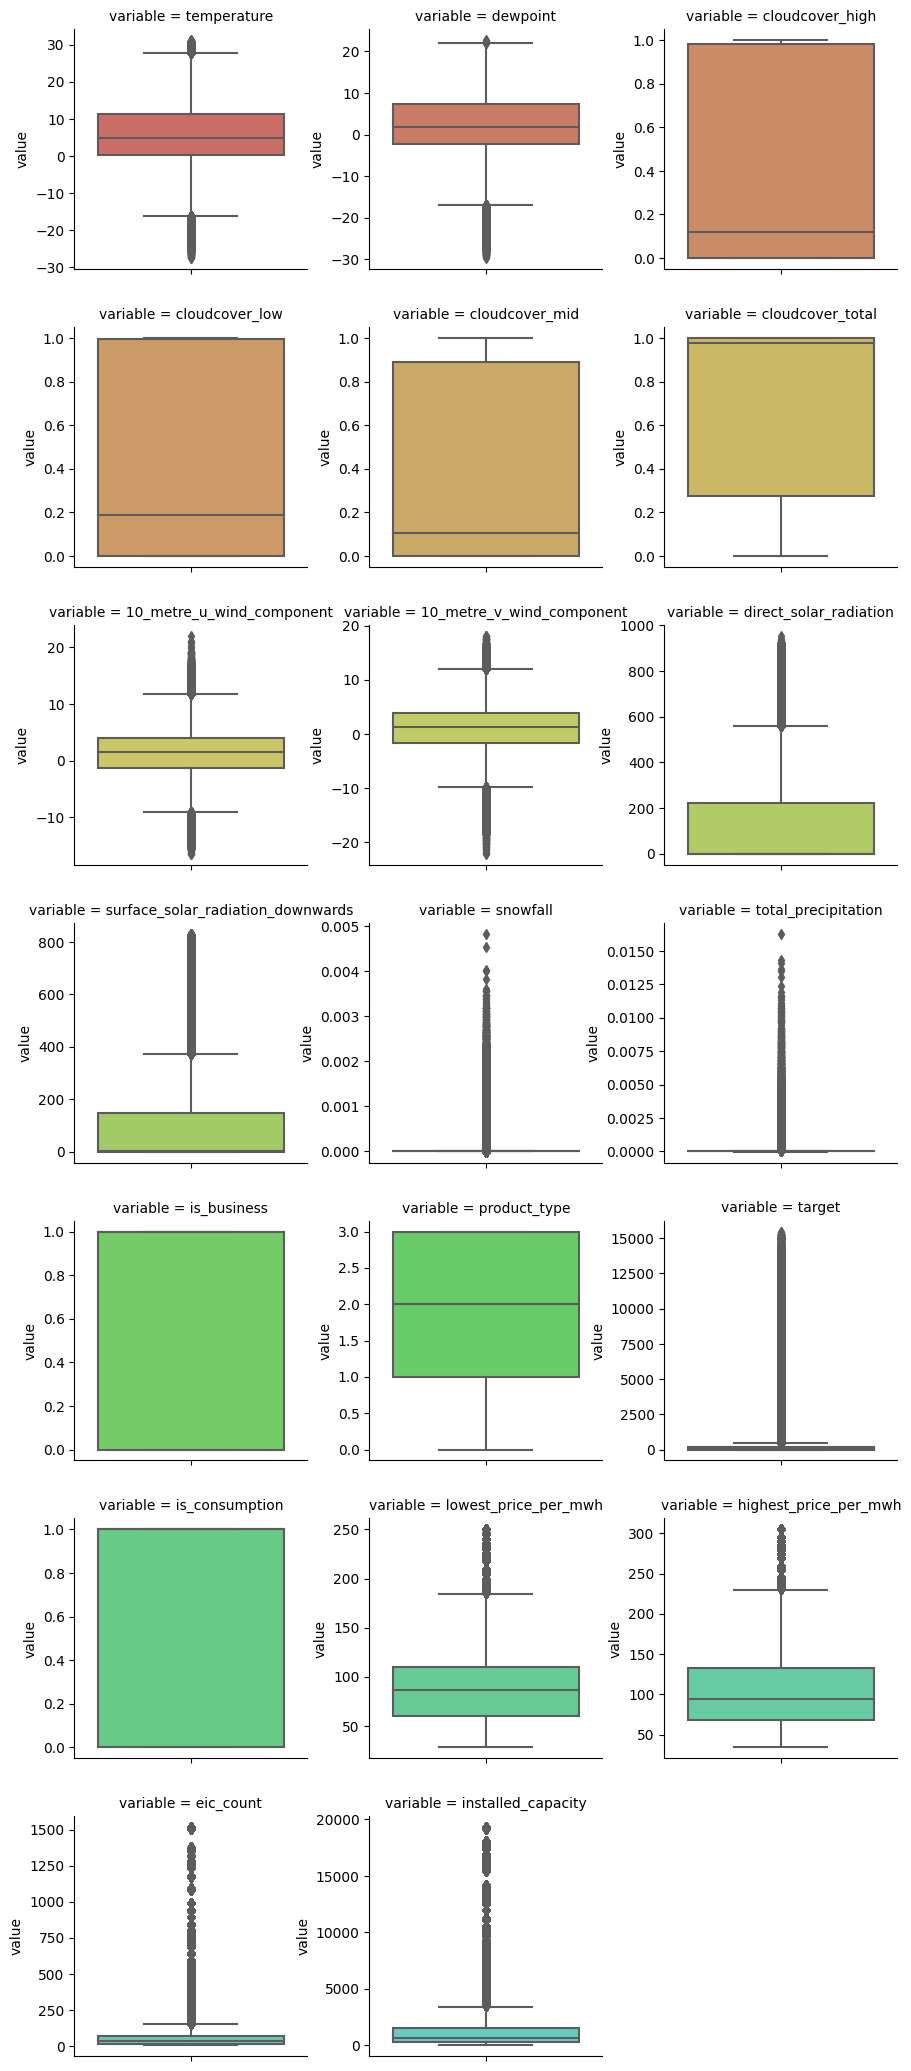

In [158]:
cols = df_train_forecast.drop(columns=[ 'latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns

f = pd.melt(df_train_forecast[cols], value_vars = cols)
g = sns.FacetGrid(f, col = 'variable',col_wrap=3, sharex=False, sharey=False)

for ax, col, color in zip(g.axes.flat,cols , sns.color_palette("hls", 40)):
    sns.boxplot(data=f[f['variable'] == col], y='value', ax=ax, color=color)

### Interprétation des Boxplots

#### Température
- **Distribution** : La température semble suivre une distribution normale avec une moyenne autour de 0.
- **Quartiles** :
  - Premier quartile (Q1) : environ 1,5 degrés.
  - Médiane : environ 6 degrés.
  - Troisième quartile (Q3) : environ 11 degrés.
- **Extrêmes** : Les valeurs varient de -30 à 31 degrés.

#### Point de Rosée
- **Distribution** : Semblable à la température, suggérant une distribution normale.
- **Quartiles** :
  - Premier quartile (Q1) : environ 0 degrés.
  - Médiane : environ 5 degrés.
  - Troisième quartile (Q3) : environ 10 degrés.
- **Extrêmes** : Les valeurs varient de -30 à 21 degrés.

#### Couverture Nuageuse
- **Cloudcover_low, Cloudcover_mid, Cloudcover_high, Cloudcover_total** :
  - **Distribution** : Fortement asymétrique avec des pics à 0 et 1.
  - **Interprétation** : Indique que la couverture nuageuse est souvent soit totalement absente (0) soit totale (1), avec peu de valeurs intermédiaires.

#### Composantes du Vent
- **10_metre_u_wind_component, 10_metre_v_wind_component** :
  - **Distribution** : Symétrique autour de 0.
  - **Quartiles** :
    - Premier quartile (Q1) : environ -2.
    - Médiane : environ 0.
    - Troisième quartile (Q3) : environ 2.
  - **Interprétation** : Suggère que les composantes du vent ont une distribution normale, avec des valeurs positives et négatives autour de la moyenne.

#### Rayonnement Solaire
- **Direct_solar_radiation, Surface_solar_radiation_downwards** :
  - **Distribution** : Très asymétrique.
  - **Quartiles** :
    - Premier quartile (Q1) : environ 50 pour Surface Solar Radiation Downwards.
    - Médiane : environ 100 pour Surface Solar Radiation Downwards.
    - Troisième quartile (Q3) : environ 200 pour Surface Solar Radiation Downwards.
  - **Extrêmes** : Des valeurs extrêmes allant jusqu'à environ 850 pour Direct Solar Radiation.

#### Précipitations Totales et Chutes de Neige
- **Total Precipitation, Snowfall** :
  - **Distribution** : Très asymétrique.
  - **Quartiles** :
    - Premier quartile (Q1) : environ 0.
    - Médiane : environ 0.
    - Troisième quartile (Q3) : environ 0.001 pour Total Precipitation.
  - **Extrêmes** : De nombreux outliers au-dessus de 0.001 pour Total Precipitation, allant jusqu'à environ 0.015.

#### Is Business
- **Distribution** : Variable binaire.
- **Valeurs** : 0 et 1.
- **Interprétation** : Indique si l'entité est une entreprise ou non.

#### Product Type
- **Distribution** : Variable catégorielle.
- **Quartiles** :
  - Premier quartile (Q1) : environ 1.
  - Médiane : environ 2.
  - Troisième quartile (Q3) : environ 2.5.
- **Interprétation** : Montre les différents types de produits.

#### Target
- **Distribution** : Très asymétrique.
- **Quartiles** :
  - Premier quartile (Q1) : environ 0.
  - Médiane : environ 0.
  - Troisième quartile (Q3) : environ 0.
- **Extrêmes** : De nombreux outliers au-dessus de 0, allant jusqu'à environ 15000.

#### Is Consumption
- **Distribution** : Variable binaire.
- **Valeurs** : 0 et 1.
- **Interprétation** : Indique si l'entité est un consommateur ou un producteur.

#### Lowest Price Per MWh
- **Distribution** : Relativement uniforme avec une concentration des valeurs autour de 100.
- **Quartiles** :
  - Premier quartile (Q1) : environ 75.
  - Médiane : environ 100.
  - Troisième quartile (Q3) : environ 150.
- **Extrêmes** : De nombreux outliers au-dessus de 150, allant jusqu'à environ 250.

#### Highest Price Per MWh
- **Distribution** : Similaire à la variable "lowest_price_per_mwh", mais avec des valeurs plus élevées.
- **Quartiles** :
  - Premier quartile (Q1) : environ 100.
  - Médiane : environ 150.
  - Troisième quartile (Q3) : environ 200.
- **Extrêmes** : De nombreux outliers au-dessus de 200, allant jusqu'à environ 300.

#### EIC Count
- **Distribution** : Très asymétrique.
- **Quartiles** :
  - Premier quartile (Q1) : environ 50.
  - Médiane : environ 100.
  - Troisième quartile (Q3) : environ 200.
- **Extrêmes** : De nombreux outliers au-dessus de 200, allant jusqu'à environ 1500.

#### Installed Capacity
- **Distribution** : Très asymétrique.
- **Quartiles** :
  - Premier quartile (Q1) : environ 500.
  - Médiane : environ 1000.
  - Troisième quartile (Q3) : environ 2000.
- **Extrêmes** : De nombreux outliers au-dessus de 2000, allant jusqu'à environ 20000.

### Conclusion
Ces boxplots montrent que :
- Les variables "surface_solar_radiation_downwards", "snowfall", et "total_precipitation" présentent une forte asymétrie avec des valeurs principalement proches de zéro et quelques valeurs très élevées.
- Les variables binaires "is_business" et "is_consumption" sont correctement représentées avec des valeurs distinctes 0 et 1.
- La variable "product_type" montre une distribution catégorielle avec plusieurs types de produits.
- La variable "target" présente une forte asymétrie avec de nombreux outliers.
- Les variables "lowest_price_per_mwh" et "highest_price_per_mwh" montrent des distributions relativement uniformes avec des valeurs plus élevées pour "highest_price_per_mwh".
- Les variables "eic_count" et "installed_capacity" montrent une forte asymétrie avec de nombreux outliers.

Ces observations suggèrent que certaines variables peuvent nécessiter des transformations pour être utilisées efficacement dans des modèles prédictifs. Par exemple, les transformations logarithmiques pourraient être utiles pour les variables de rayonnement solaire et de précipitations totales pour réduire leur asymétrie.

    - 

# 2.2 features engineering

In [36]:
cols = df_train_forecast.drop(columns=[ 'latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns


In [37]:
df_train_forecast_log = df_train_forecast[cols]

for column in cols:
    df_train_forecast_log[column] = np.log(df_train_forecast[column] + 1)

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_34/848313076.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_forecast_log[column] = np.log(df_train_forecast[column] + 1)


In [38]:
def new_features(df_features):
    
        df_features["hour"] = df_features["datetime"].dt.hour
        df_features["day"] = df_features["datetime"].dt.day
        df_features["weekday"] = df_features["datetime"].dt.weekday
        df_features["month"] = df_features["datetime"].dt.month
        df_features["year"] = df_features["datetime"].dt.year
        df_features["dayofyear"] = df_features["datetime"].dt.dayofyear
        
        # Ajouter les colonnes sinusoïdales pour capturer la cyclicité
        df_features["sin_dayofyear"] = np.sin(np.pi * df_features["dayofyear"] / 183)
        df_features["cos_dayofyear"] = np.cos(np.pi * df_features["dayofyear"] / 183)
        df_features["sin_hour"] = np.sin(np.pi * df_features["hour"] / 12)
        df_features["cos_hour"] = np.cos(np.pi * df_features["hour"] / 12)
        
        return df_features

In [40]:
df_train_forecast['datetime'] = df_train_forecast.index
df_train_forecast2 = new_features(df_train_forecast)

cols = df_train_forecast2.drop(columns=['latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime','datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns
cols

Index(['temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 'direct_solar_radiation',
       'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation',
       'is_business', 'product_type', 'target', 'is_consumption',
       'lowest_price_per_mwh', 'highest_price_per_mwh', 'eic_count',
       'installed_capacity', 'hour', 'day', 'weekday', 'month', 'year',
       'dayofyear', 'sin_dayofyear', 'cos_dayofyear', 'sin_hour', 'cos_hour'],
      dtype='object')

# 2.3 Analyse de colinéarité

In [36]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X = sm.add_constant(df_train_forecast2[cols])
# Sélectionner les colonnes pertinentes pour le calcul du VIF
X = X.drop(columns='target')
# constante pour le calcul du VIF
X = sm.add_constant(X)

# Calcule le VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                             Variable           VIF
0                               const  2.093969e+07
1                         temperature  1.555816e+01
2                            dewpoint  1.224473e+01
3                     cloudcover_high  2.135487e+00
4                      cloudcover_low  2.616975e+00
5                      cloudcover_mid  1.695600e+00
6                    cloudcover_total  3.585199e+00
7           10_metre_u_wind_component  1.163214e+00
8           10_metre_v_wind_component  1.186063e+00
9              direct_solar_radiation  6.738046e+00
10  surface_solar_radiation_downwards  6.915805e+00
11                           snowfall  1.377152e+00
12                total_precipitation  1.428389e+00
13                        is_business  1.314035e+00
14                       product_type  1.145103e+00
15                     is_consumption  1.000818e+00
16               lowest_price_per_mwh  2.947276e+01
17              highest_price_per_mwh  2.928927e+01
18          

In [83]:
df_train_forecast2[cols].describe().iloc[:,:20]

,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,is_business,product_type,target,is_consumption,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity
count,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06,2009710.0,2.009710e+06,2.009710e+06,2.009710e+06,2.009710e+06
mean,5.649384e+00,2.298356e+00,4.068336e-01,4.140119e-01,3.583144e-01,6.833568e-01,1.420097e+00,1.050718e+00,1.529539e+02,1.113298e+02,2.510803e-05,7.883715e-05,5.366973e-01,1.898971e+00,2.753058e+02,0.5,9.556074e+01,1.084196e+02,7.342623e+01,1.452344e+03
std,7.834997e+00,7.152849e+00,4.459749e-01,4.352261e-01,4.183819e-01,3.988468e-01,3.979913e+00,4.205521e+00,2.569471e+02,1.867504e+02,1.223223e-04,2.752820e-04,4.986516e-01,1.082261e+00,9.105864e+02,0.5,4.757702e+01,5.474951e+01,1.441296e+02,2.423212e+03
min,-2.749940e+01,-2.968357e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.640865e+01,-2.211612e+01,-7.733333e-01,-3.258333e-01,-3.814697e-06,-1.529098e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.0,2.810000e+01,3.400000e+01,5.000000e+00,6.000000e+00
25%,3.701416e-01,-2.339331e+00,0.000000e+00,3.051758e-05,0.000000e+00,2.740173e-01,-1.255646e+00,-1.648080e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.800000e-01,0.0,6.000000e+01,6.769000e+01,1.400000e+01,3.237000e+02
50%,4.852686e+00,1.743799e+00,1.196442e-01,1.889954e-01,1.060797e-01,9.749445e-01,1.580403e+00,1.243975e+00,0.000000e+00,6.322222e-01,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,3.130000e+01,1.0,8.600000e+01,9.400000e+01,3.200000e+01,6.470800e+02
75%,1.132534e+01,7.382639e+00,9.841614e-01,9.973755e-01,8.913879e-01,9.999999e-01,3.978495e+00,3.813097e+00,2.231897e+02,1.487806e+02,0.000000e+00,2.647305e-05,1.000000e+00,3.000000e+00,1.808800e+02,1.0,1.097400e+02,1.330000e+02,7.000000e+01,1.567150e+03
max,3.124551e+01,2.267642e+01,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,2.203584e+01,1.810218e+01,9.544222e+02,8.319411e+02,4.832983e-03,1.629448e-02,1.000000e+00,3.000000e+00,1.548027e+04,1.0,2.500000e+02,3.050000e+02,1.517000e+03,1.931431e+04


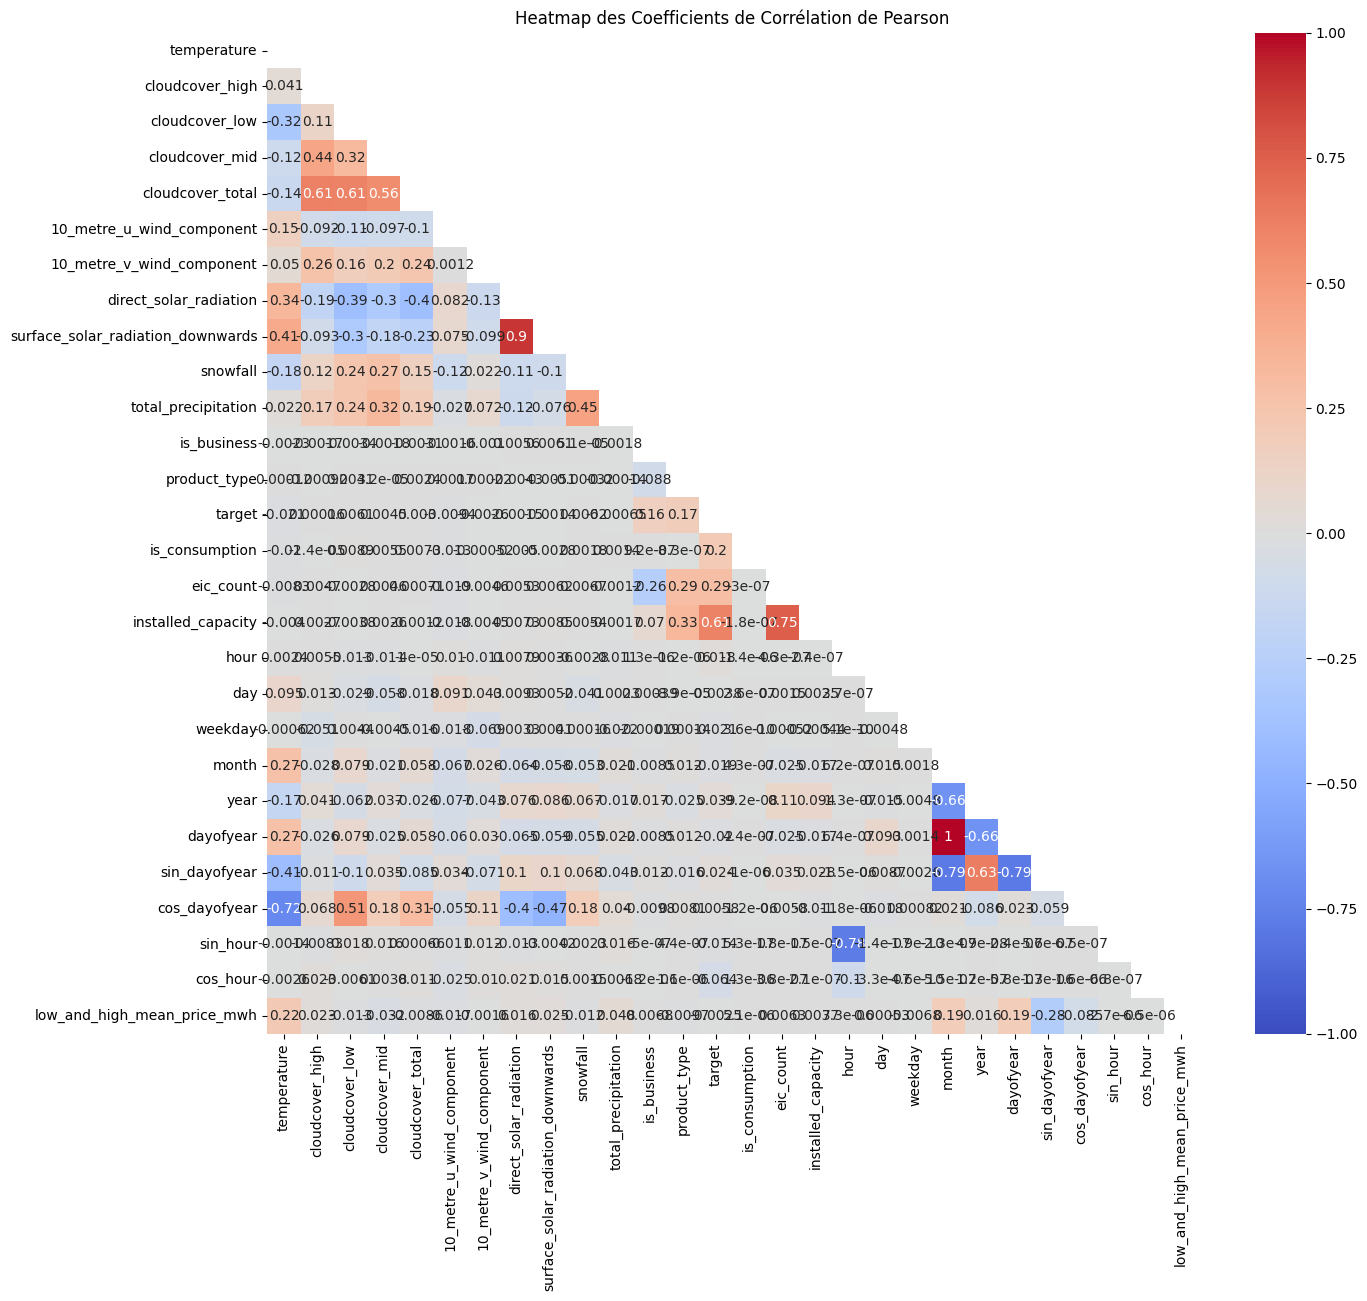

In [100]:
corr_matrix = df_train_forecast2[cols].corr(method='pearson')
# Créer une heatmap avec Seaborn
plt.figure(figsize=(15, 13))
mask = np.triu(corr_matrix)
sns.heatmap(data = corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask = mask)
plt.title('Heatmap des Coefficients de Corrélation de Pearson')
plt.show()

## Multicolinéarité

- **Variable Cible et Capacité Installée** : La variable cible a une corrélation de 0,61 avec la variable de capacité installée. Bien que cette corrélation soit modérée, elle n'est pas suffisamment forte pour suggérer des problèmes de multicolinéarité significatifs à elle seule.

- **Prix Minimum par MWh et Prix Maximum par MWh** : Les deux variables présentent des valeurs VIF élevées (27,37 et 27,09 respectivement), indiquant un degré très élevé de multicolinéarité entre ces deux variables. Cette forte colinéarité peut être problématique car elle peut gonfler les erreurs standard des coefficients et rendre les coefficients du modèle instables et moins interprétables.

- **Température et Point de Rosée** : La variable température a un VIF de 13,63 et la variable point de rosée a un VIF de 11,96. Ces valeurs VIF élevées suggèrent une multicolinéarité significative entre ces deux variables. Étant donné la forte corrélation entre la température et le point de rosée, il est conseillé de supprimer la variable point de rosée du modèle pour atténuer ce problème.


In [41]:
# the new variables is the addition of lowest anµd highest price per mwh variables 
df_train_forecast2['low_and_high_delta_price_mwh'] =  df_train_forecast2.highest_price_per_mwh - df_train_forecast2.lowest_price_per_mwh  

In [42]:
# i remove the variable dewpoint, lowest_price_per_mwh and, highest_price_per_mwh to avoid the colinearity
df_train_forecast2.drop(columns = ['dewpoint','lowest_price_per_mwh','highest_price_per_mwh'] , inplace=True)

# 3 Modelisation

## 3.1 Prediction de la variale target avec le modèle Sarimax

 - statistic test ADU (analyse if the serie is staionar)
 - analyse the autocorrelation and partial autocorrelation 
 - predict the value with the model Sarimax
 - conclusion about the prediction.

## 3.2 Prediction de la variale target avec le modèle Xgboost
  - Evaluation du MAE avec le modèle par défault
  - Optimlisation du modèle avec une recherche par grille des hyperparamètres
  - Eévaluation du MAE avce les paramètres retenu 
  
## 3.3 Prédiction de la variable target avec le réseau de neurone LSTM

 

# 3.1 Prediction de la variale target avec le modèle Sarimax

## Test statistique de stationnarité ADU

In [35]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

# H0 -> les données ne sont pas stationnaires 
# H1 -> les données sont stationnaires
# Vérifier la stationnarité initiale
result_adf = adfuller(df_train_forecast['target'].iloc[:100000])
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])

# Différencier la série si elle n'est pas stationnaire

# Vérifier la stationnarité après différenciation
result_adf_diff = adfuller(df_train_forecast['target'].diff(1).dropna().iloc[:100000])
print('ADF Statistic (diff):', result_adf_diff[0])
print('p-value (diff):', result_adf_diff[1])


ADF Statistic: -47.77838471730678
p-value: 0.0
ADF Statistic (diff): -47.630623412216025
p-value (diff): 0.0


- Le test statistique Adfuller permet de vérifier la stationnarité d'une ésrie chronologique
- A la suite du test , la série semble être stationnaire sans différentiation. La P-value est inférieure au seuil critique fixé à 0.05 (5 pourcents)

## Analyse series without differentiation

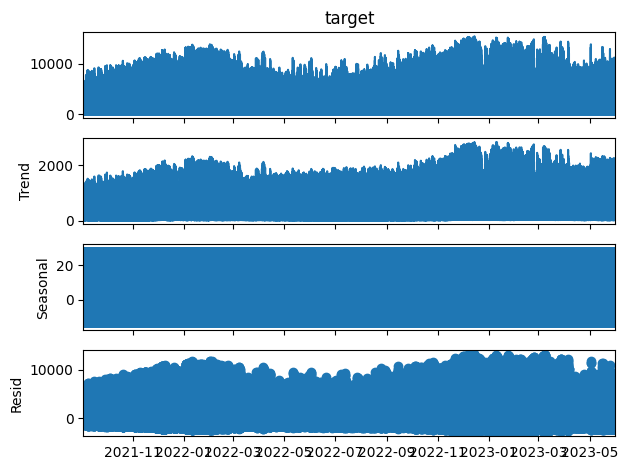

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Décomposition additive
result_add = seasonal_decompose(df_train_forecast['target'], model='additive', period=7)
result_add.plot()
plt.show()


In [40]:
trend = result_add.trend.loc[result_add.trend.index.year == 2022]
resid = result_add.resid.loc[result_add.resid.index.year == 2022]
season = result_add.seasonal.loc[result_add.seasonal.index.year == 2022]


print('residu var =',resid.var(),'residu mean', round(resid.mean(),4))

residu var = 686779.1886949935 residu mean 0.0


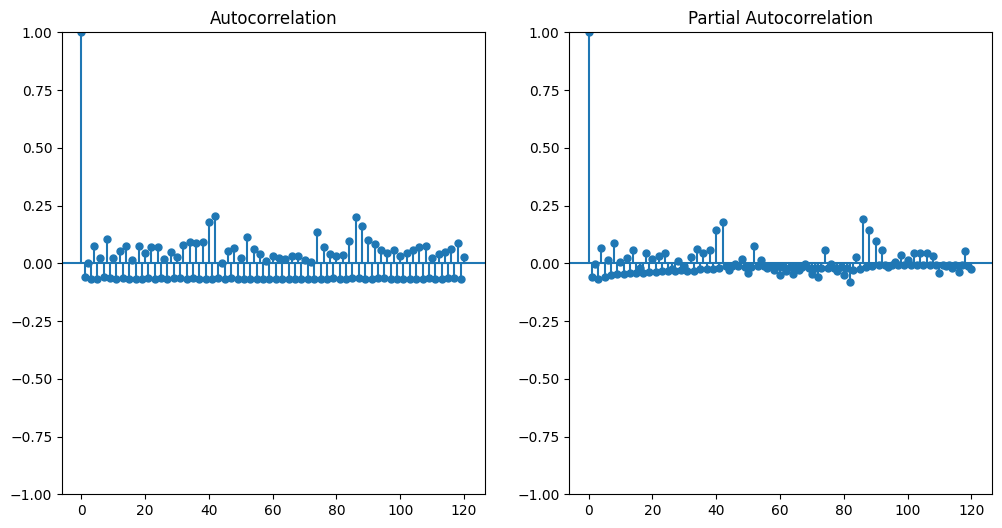

In [41]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

plot_acf(df_train_forecast.target.iloc[:500000],lags=120,ax=ax[0])
plot_pacf(df_train_forecast.target.iloc[:500000],lags=120, ax=ax[1])

plt.show()

- In the autocorrelation graph, the value decreases at the first lag, but the confidence interval is very small. We cannot be sure that the prediction will be accurate for the real value.

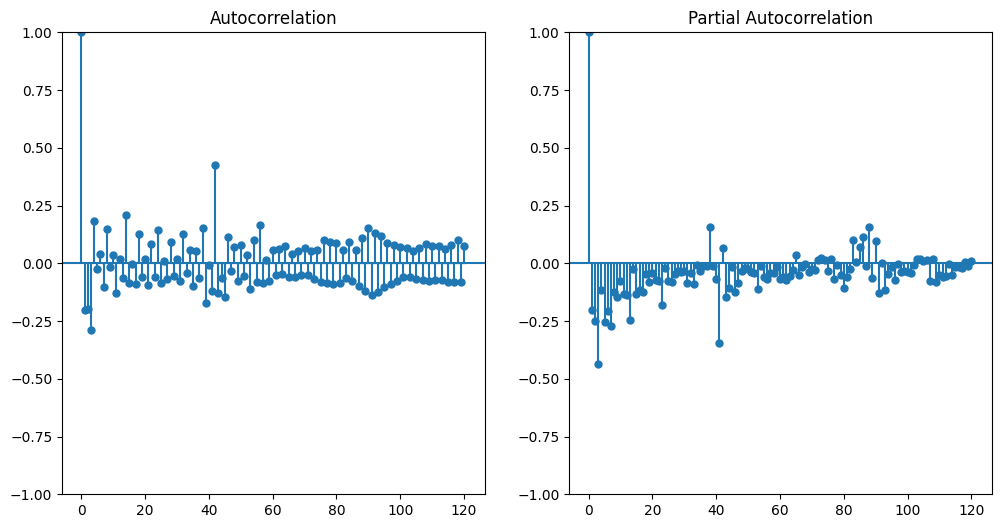

In [91]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

plot_acf(resid[:500000],lags=120,ax=ax[0])
plot_pacf(resid[:500000],lags=120, ax=ax[1])

plt.show()

## Analyze ACF and PACF resid with 1 differianciation

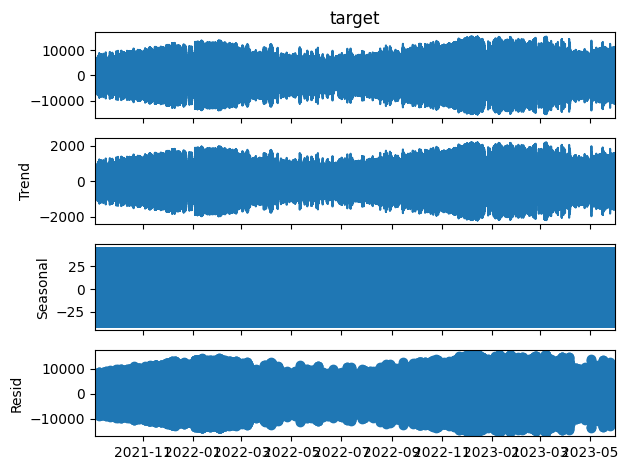

In [92]:
# Décomposition additive
result_add = seasonal_decompose(df_train_forecast['target'].diff(1).dropna(), model='additive', period=7)
result_add.plot()
plt.show()



In [93]:
trend = result_add.trend.loc[result_add.trend.index.year == 2022]
resid = result_add.resid.loc[result_add.resid.index.year == 2022]
season = result_add.seasonal.loc[result_add.seasonal.index.year == 2022]
season.shape

print('residu var =',resid.var(),'residu mean', round(resid.mean(),4))

residu var = 1658639.765644543 residu mean 0.0001


In [94]:
df = df_train_forecast.loc[df_train_forecast.index.year == 2022, 'target'].iloc[:500000]
df.index = df.index.normalize()
df

datetime
2022-01-01      0.000
2022-01-01    442.226
2022-01-01      0.000
2022-01-01     44.899
2022-01-01      0.015
               ...   
2022-06-06     29.386
2022-06-06     26.770
2022-06-06    289.254
2022-06-06     18.721
2022-06-06    296.364
Name: target, Length: 500000, dtype: float64

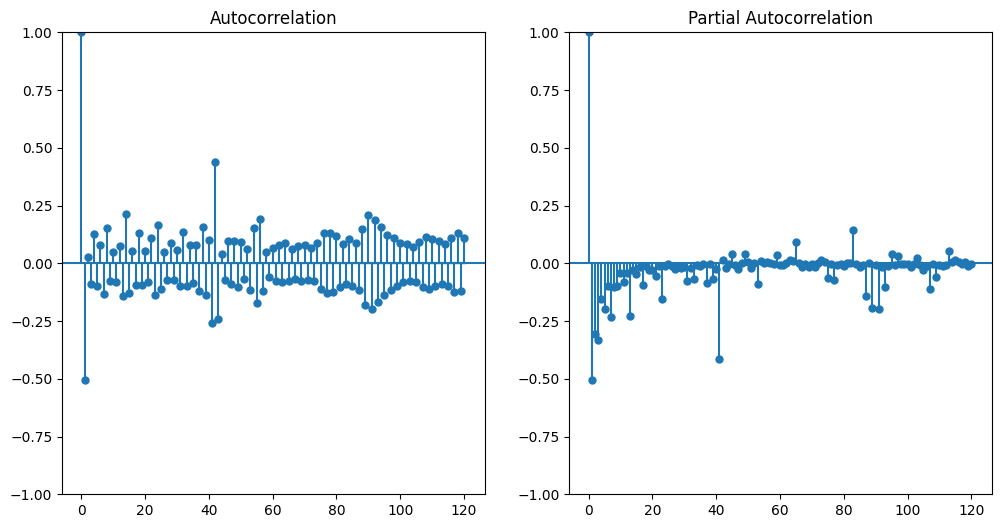

In [95]:


fig, ax = plt.subplots(1,2, figsize = (12,6))

plot_acf(df.diff(1).dropna(),lags=120,ax=ax[0])
plot_pacf(df.diff(1).dropna(),lags=120, ax=ax[1])

plt.show()


- In the autocorrelation graph, the model at the first lag shows a negative value that is outside the confidence interval. In the next lags, the values fluctuate between 0.10 and -0.10. We observe a strong peak at the 40th lag.
- In the partial autocorrelation graph, the model at the first lag shows a negative value. For the next lags, the values approach zero by the 20th lag. 


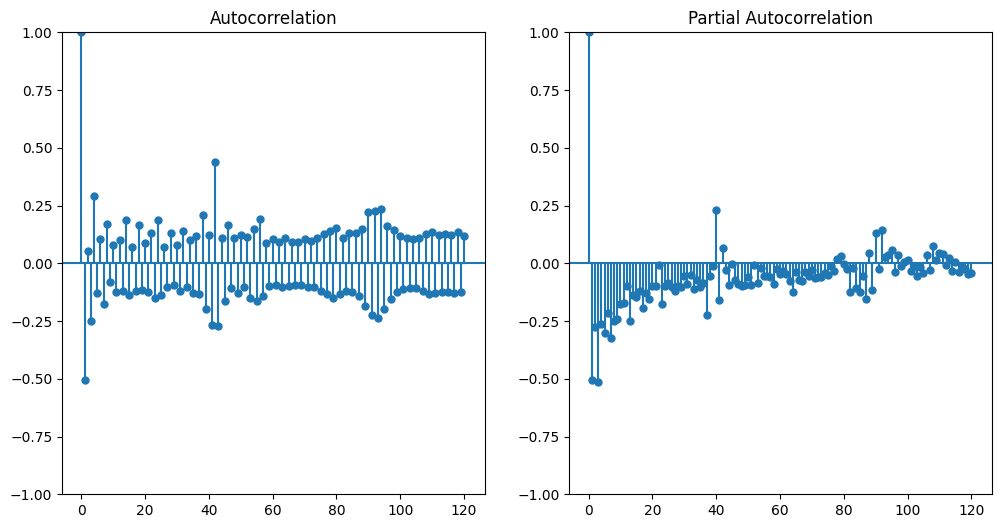

In [96]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

plot_acf(resid,lags=120,ax=ax[0])
plot_pacf(resid,lags=120, ax=ax[1])

plt.show()


## Predict values with the model Sarima without differentiation (date 2022-01_01 à 2022-02-02) 

In [167]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX



# Ajouter des variables exogènes si disponibles (par exemple, température, radiation solaire)
exog_variables = df_train_forecast[['temperature','cloudcover_high', 'cloudcover_low','direct_solar_radiation', 'surface_solar_radiation_downwards']]
# Synchroniser les indices des variables exogènes avec les composantes de la série temporelle
exog_train = exog_variables.loc[exog_variables.index.year==2022].iloc[:100000]
exog_test = exog_variables.loc[exog_variables.index.year==2022].iloc[100000:110000]  # Par exemple, pour les 12 derniers mois

endo_train = df_train_forecast.target.loc[df_train_forecast.target.index.year == 2022].iloc[:100000]
endo_test = df_train_forecast.target.loc[df_train_forecast.target.index.year == 2022].iloc[100000:110000]


# Utiliser les composantes pour la modélisation
# Séparation des données en ensemble d'entraînement et de testdf_train_forecast.diff(7).dropna()iloc[:500000]
# Prédictions sur la tendance
# Utiliser un modèle SARIMAX avec une saisonnalité ajustée
try:
    model = SARIMAX(endo_train,
                    order=(1, 0, 1), 
                    seasonal_order=(1, 0, 1, 7),  # Saisonnalité réduite à 7 jours
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    
    
    fit = model.fit(disp=False)
    print(fit.summary())

except MemoryError as e:
    print(f"MemoryError: {e}")

except Exception as e:
    print(f"Error: {e}")



/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                            target   No. Observations:               100000
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood             -833686.926
Date:                           Mon, 15 Jul 2024   AIC                        1667383.851
Time:                                   17:37:05   BIC                        1667431.416
Sample:                                        0   HQIC                       1667398.286
                                        - 100000                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5576      0.093      6.002      0.000       0.376       0.740
ma.L1         -0.6139      0.089     -6.921

In [ ]:
forecast_test = fit.forecast(steps=exog_test.shape[0])
forecast_test

In [ ]:
df_fore = pd.Series(data=forecast_test.values, index=exog_test.index.values)
fig,ax = plt.subplots(2,1,figsize=(10,7))
#exog_train.plot(ax=ax[0])
exog_test.plot(ax=ax[0])
df_fore.plot(ax=ax[1], color='orange')

plt.tight_layout()
plt.show()

In [ ]:
#display(pd.concat([df_fore, test_trend], axis=1))
mse = np.sqrt(mean_squared_error(forecast_test, exog_test))
print(f'MSE: {mse}')

## Predict values with Sarima with 1 differianciation (date 2022-01_01 à 2022-02-02) 

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX



# Ajouter des variables exogènes si disponibles (par exemple, température, radiation solaire)
exog_variables = df_train_forecast[['temperature','cloudcover_high', 'cloudcover_low','direct_solar_radiation', 'surface_solar_radiation_downwards']]
# Synchroniser les indices des variables exogènes avec les composantes de la série temporelle
exog_train = exog_variables.loc[exog_variables.index.year==2022].iloc[:100000]
exog_test = exog_variables.loc[exog_variables.index.year==2022].iloc[100000:110000]  # Par exemple, pour les 12 derniers mois

endo_train = df_train_forecast.target.loc[df_train_forecast.target.index.year == 2022].iloc[:100000]
endo_test = df_train_forecast.target.loc[df_train_forecast.target.index.year == 2022].iloc[100000:110000]


# Utiliser les composantes pour la modélisation
# Séparation des données en ensemble d'entraînement et de testdf_train_forecast.diff(7).dropna()iloc[:500000]
# Prédictions sur la tendance
# Utiliser un modèle SARIMAX avec une saisonnalité ajustée
try:
    model = SARIMAX(endo_train,
                    order=(1, 1, 1), 
                    seasonal_order=(1, 1, 1, 7),  # Saisonnalité réduite à 7 jours
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    
    
    fit = model.fit(disp=False)
    print(fit.summary())

except MemoryError as e:
    print(f"MemoryError: {e}")

except Exception as e:
    print(f"Error: {e}")



/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                            target   No. Observations:               100000
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood             -851123.738
Date:                           Mon, 15 Jul 2024   AIC                        1702257.476
Time:                                   17:46:56   BIC                        1702305.040
Sample:                                        0   HQIC                       1702271.911
                                        - 100000                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0597      0.025     -2.342      0.019      -0.110      -0.010
ma.L1         -0.9989      0.000  -2083.852

In [210]:
forecast_test = fit.forecast(steps=endo_test.shape[0])
forecast_test

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


100000    295.620832
100001    283.503344
100002    280.964011
100003    284.831860
100004    251.386915
             ...    
109995    271.717554
109996    273.781162
109997    272.225972
109998    271.426910
109999    272.712554
Name: predicted_mean, Length: 10000, dtype: float64

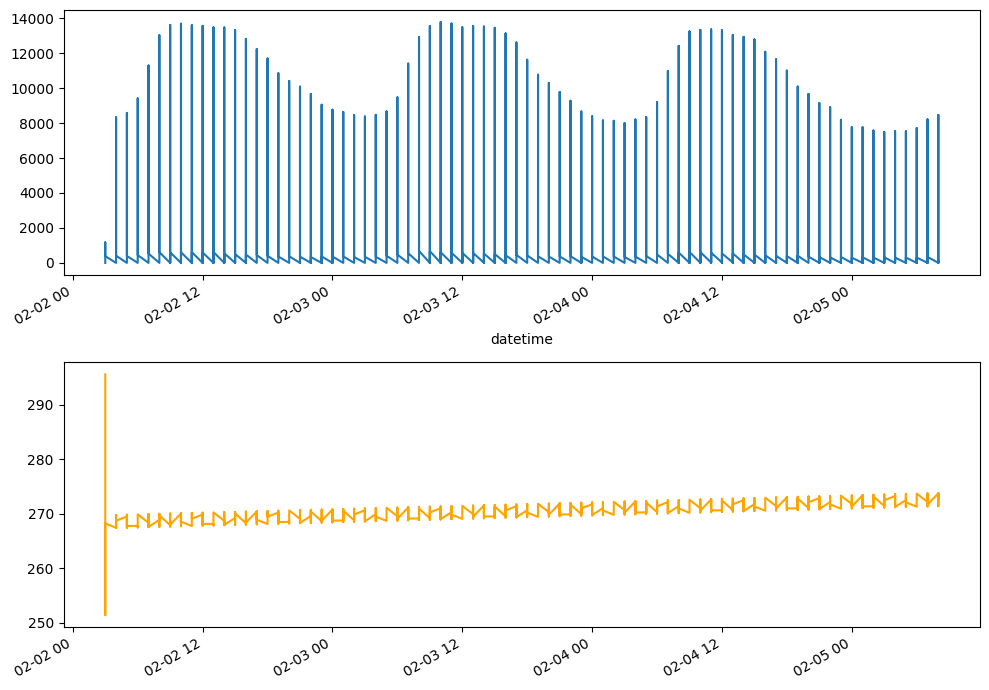

In [211]:
df_fore = pd.Series(data=forecast_test.values, index=exog_test.index.values)
fig,ax = plt.subplots(2,1,figsize=(10,7))
#exog_train.plot(ax=ax[0])
endo_test.plot(ax=ax[0])
df_fore.plot(ax=ax[1], color='orange')

plt.tight_layout()
plt.show()

In [189]:
#display(pd.concat([df_fore, test_trend], axis=1))
mse = np.sqrt(mean_squared_error(forecast_test, endo_test))
print(f'MSE: {mse}')

MSE: 1117.408410447193


## Predict values with Sarima with features lags (date 2022-01_01 à 2022-02-02)  

In [190]:
# Exemple de création de variables retardées

endo_train = df_train_forecast.target.loc[df_train_forecast.target.index.year == 2022].iloc[:100000]
endo_test = df_train_forecast.target.loc[df_train_forecast.target.index.year == 2022].iloc[100000:110000]

def create_lagged_features(df, target,lags):
    for lag in lags:
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df

lags = [1, 2, 3, 7, 14, 40] 
X_train = create_lagged_features(pd.DataFrame(endo_train),'target',lags=lags)
X_train.dropna(inplace=True)
X_test = create_lagged_features(pd.DataFrame(endo_test),'target',lags=lags)
X_test.dropna(inplace=True)


In [191]:
X_train.drop(columns='target', inplace=True)
X_test.drop(columns='target', inplace=True)


In [192]:
y_test_reset = endo_test.iloc[:X_test.shape[0]].reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Utiliser un modèle SARIMAX avec une saisonnalité ajustée
try:
    model = SARIMAX(
                    endog=y_train_reset,
                    order=(1, 1, 1), 
                    seasonal_order=(1, 1, 1, 7),  # Saisonnalité réduite à 7 jours
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    
    
    fit = model.fit(disp=False)
    print(fit.summary())

except MemoryError as e:
    print(f"MemoryError: {e}")

except Exception as e:
    print(f"Error: {e}")



Error: name 'y_train_reset' is not defined


In [194]:
forecast_test = fit.forecast(steps=y_test_reset.shape[0])


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


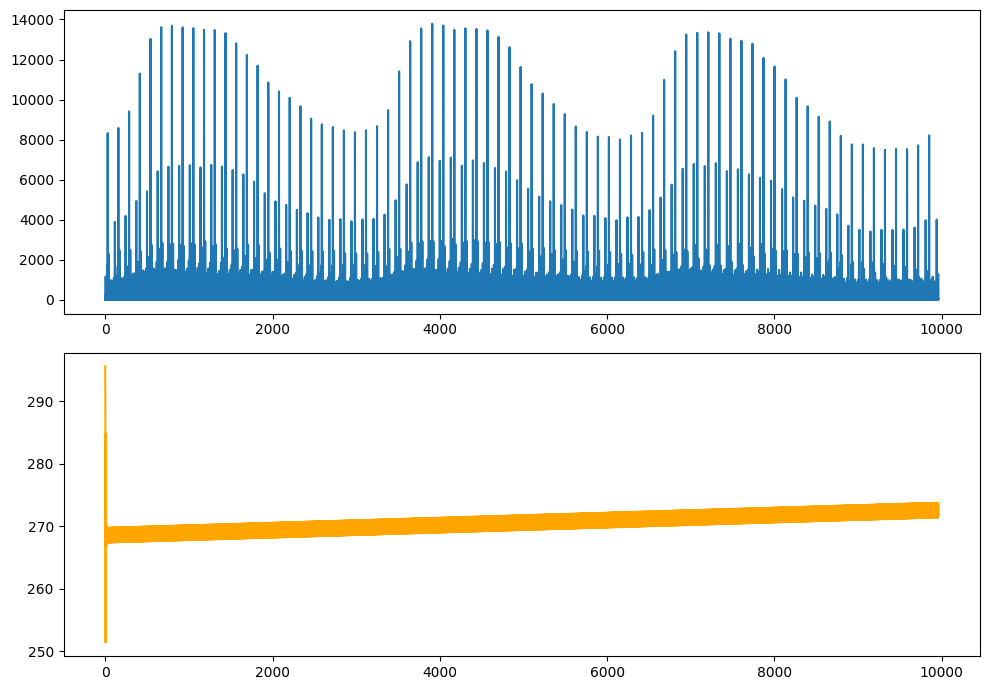

In [195]:
df_fore = pd.Series(data=forecast_test.values, index=y_test_reset.index)
fig,ax = plt.subplots(2,1,figsize=(10,7))
y_test_reset.plot(ax=ax[0])
df_fore.plot(ax=ax[1], color='orange')
plt.tight_layout()

In [196]:
mse = np.sqrt(mean_squared_error(forecast_test , y_test_reset))
print(f'MSE: {mse}')

MSE: 1116.4254265433303


# 3.2 Prediction de la variale target avec le modèle Xgboost

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import time


In [44]:
cols = df_train_forecast2.drop(columns=[ 'latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime','datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns
cols

Index(['temperature', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 'direct_solar_radiation',
       'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation',
       'is_business', 'product_type', 'target', 'is_consumption', 'eic_count',
       'installed_capacity', 'hour', 'day', 'weekday', 'month', 'year',
       'dayofyear', 'sin_dayofyear', 'cos_dayofyear', 'sin_hour', 'cos_hour',
       'low_and_high_delta_price_mwh'],
      dtype='object')

In [48]:

# Synchroniser les indices des variables exogènes avec les composantes de la série temporelle
X_train = df_train_forecast2.loc[(df_train_forecast2.index.year>=2021)&(df_train_forecast2.index.year<=2022), cols]
X_test = df_train_forecast2.loc[(df_train_forecast2.index.year==2023), cols]
# Utiliser les composantes pour la modélisation
# Séparation des données en ensemble d'entraînement et de test
y_train = df_train_forecast2.target.loc[(df_train_forecast2.index.year>=2021)&(df_train_forecast2.index.year<=2022)]
y_test = df_train_forecast2.target.loc[(df_train_forecast2.target.index.year == 2023)]



In [49]:

# Exemple de création de variables retardées
def create_lagged_features(df, target,lags):
    for lag in lags:
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df

lags = [1, 2, 3, 7, 14, 40] 
X_train_lag = create_lagged_features(X_train,'target',lags=lags)
X_train_lag.dropna(inplace=True)
X_test_lag = create_lagged_features(X_test,'target',lags=lags)
X_test_lag.dropna(inplace=True)

In [50]:
X_train_lag.drop(columns='target',inplace=True)
X_test_lag.drop(columns='target',inplace=True)

temps d execution :  5.01953387260437


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:40:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


RMSE: 348.35719131509785


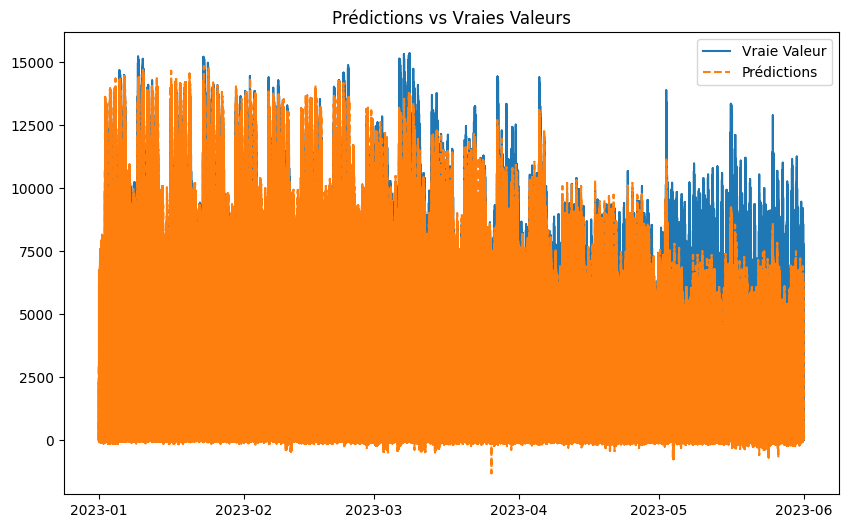

In [51]:
t1 = time.time()
# Créer et entraîner le modèle XGBoost
model = XGBRegressor(objective='reg:squarederror',tree_method='hist', device='cuda')
model.fit(X_train_lag, y_train[40:])
t2 = time.time()
print('temps d execution : ', (t2-t1))
# Faire des prédictions
y_pred = model.predict(X_test_lag)

# Calculer l'erreur quadratique moyenne
rmse = np.sqrt(mean_squared_error(y_test[40:], y_pred))
print(f'RMSE: {rmse}')

# Meilleurs paramètres trouvés : {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}
# Meilleurs paramètres trouvés : {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}

plt.figure(figsize=(10, 6))
plt.plot(y_test.index[40:], y_test[40:], label='Vraie Valeur')
plt.plot(y_test.index[40:], y_pred, label='Prédictions', linestyle='--')
plt.legend()
plt.title('Prédictions vs Vraies Valeurs')
plt.show()


In [52]:
# récupère la consommation et la production du mois de février 2023
X_test2 = df_train_forecast2.loc[(df_train_forecast2.index.year==2023)&(df_train_forecast2.target.index.month == 2), cols]
y_test2 = df_train_forecast2.target.loc[(df_train_forecast2.target.index.year == 2023)&(df_train_forecast2.target.index.month == 2)]

X_test2_lag = create_lagged_features(X_test2,'target',lags=lags)
X_test2_lag.dropna(inplace=True)

X_test2_lag.drop(columns=['target'],inplace=True)

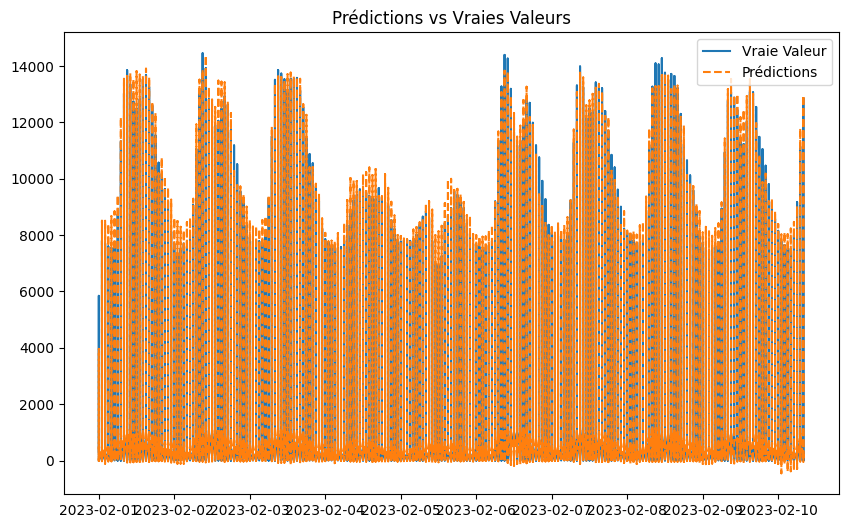

In [53]:
# Faire des prédictions
y_pred = model.predict(X_test2_lag)


plt.figure(figsize=(10, 6))
plt.plot(y_test2[40:30000].index, y_test2[40:30000], label='Vraie Valeur')
plt.plot(y_test2[40:30000].index, y_pred[:29960], label='Prédictions', linestyle='--')
plt.legend()
plt.title('Prédictions vs Vraies Valeurs')
plt.show()

## Searching the best parameters Xgboost

In [50]:
"""from sklearn.model_selection import TimeSeriesSplit, GridSearchCV


# Définir le modèle XGBoost
model = XGBRegressor(objective='reg:squarederror', tree_method='hist', device='cuda')

# Définir la grille de paramètres
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [6, 10, 12],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=3)


# Configurer la recherche par grille
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=1, n_jobs=-1)

# Ajuster le modèle
grid_search.fit(X_train, y_train[40:])

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)

# Utiliser le meilleur modèle trouvé pour faire des prédictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculer l'erreur quadratique moyenne
rmse = np.sqrt(mean_squared_error(y_test[40:], y_pred))
print(f'RMSE: {rmse}')
"""

'from sklearn.model_selection import TimeSeriesSplit, GridSearchCV\n\n\n# Définir le modèle XGBoost\nmodel = XGBRegressor(objective=\'reg:squarederror\', tree_method=\'hist\', device=\'cuda\')\n\n# Définir la grille de paramètres\nparam_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'learning_rate\': [0.01, 0.1, 0.2],\n    \'max_depth\': [6, 10, 12],\n    \'subsample\': [0.6, 0.8, 1.0],\n    \'colsample_bytree\': [0.6, 0.8, 1.0]\n}\n\ntscv = TimeSeriesSplit(n_splits=3)\n\n\n# Configurer la recherche par grille\ngrid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=\'neg_mean_squared_error\', cv=tscv, verbose=1, n_jobs=-1)\n\n# Ajuster le modèle\ngrid_search.fit(X_train, y_train[40:])\n\n# Afficher les meilleurs paramètres\nprint("Meilleurs paramètres trouvés :", grid_search.best_params_)\n\n# Utiliser le meilleur modèle trouvé pour faire des prédictions\nbest_model = grid_search.best_estimator_\ny_pred = best_model.predict(X_test)\n\n# Calculer l\'erreur qu

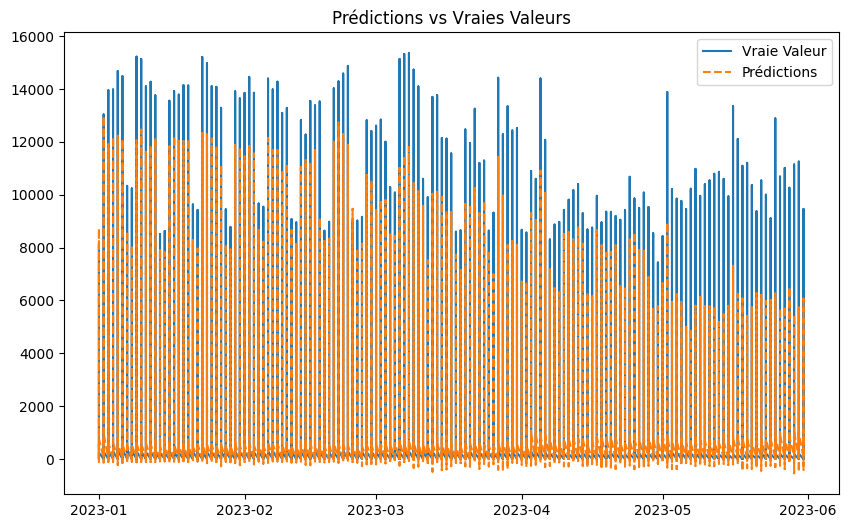

In [69]:
"""
# Tracer les prédictions vs vraies valeurs
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Vraie Valeur')
plt.plot(y_test.index[40:], y_pred, label='Prédictions', linestyle='--')
plt.legend()
plt.title('Prédictions vs Vraies Valeurs')
plt.show()
"""

# Prediction des valeurs avec les paramètres retenus de la recheche par grille (Xgboost)

temps d execution :  6.980186462402344
RMSE: 100.40113430060485


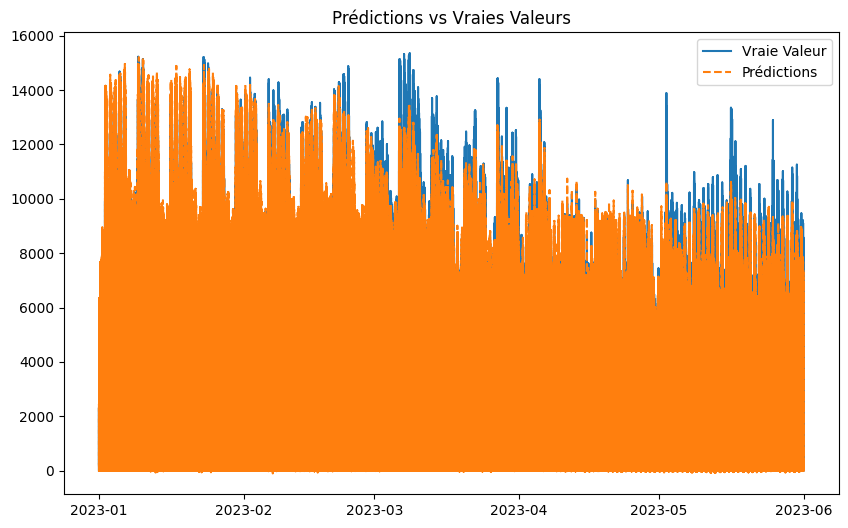

In [54]:
import time

cols = df_train_forecast2.drop(columns=[ 'latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime','datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns

# Synchroniser les indices des variables exogènes avec les composantes de la série temporelle
X_train = df_train_forecast2.loc[(df_train_forecast2.index.year>=2021)&(df_train_forecast2.index.year<=2022), cols]
X_test = df_train_forecast2.loc[(df_train_forecast2.index.year==2023), cols]
# Utiliser les composantes pour la modélisation
# Séparation des données en ensemble d'entraînement et de test
y_train = df_train_forecast2.target.loc[(df_train_forecast2.index.year>=2021)&(df_train_forecast2.index.year<=2022)]
y_test = df_train_forecast2.target.loc[(df_train_forecast2.target.index.year == 2023)]

lags = [1, 2, 3, 7, 14, 40] 

X_train_lag = create_lagged_features(X_train,'target',lags=lags)
X_train_lag.dropna(inplace=True)
X_test_lag = create_lagged_features(X_test,'target',lags=lags)
X_test_lag.dropna(inplace=True)

t1 = time.time()
# Créer et entraîner le modèle XGBoost
model = XGBRegressor(objective='reg:squarederror', subsample = 0.6, n_estimators=300, learning_rate=0.1, max_depth=6,tree_method='hist', device='cuda')
model.fit(X_train_lag, y_train[40:])
t2 = time.time()
print('temps d execution : ', (t2-t1))# Meilleurs paramètres trouvés : {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}
# Meilleurs paramètres trouvés : {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}
# Faire des prédictions
y_pred = model.predict(X_test_lag)

# Calculer l'erreur quadratique moyenne
rmse = np.sqrt(mean_squared_error(y_test[40:], y_pred))
print(f'RMSE: {rmse}')

plt.figure(figsize=(10, 6))
plt.plot(y_test.index[40:], y_test[40:], label='Vraie Valeur')
plt.plot(y_test.index[40:], y_pred, label='Prédictions', linestyle='--')
plt.legend()
plt.title('Prédictions vs Vraies Valeurs')
plt.show()

# Submit to competition

In [56]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [57]:
counter = 0
for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
    if counter == 0:
        display(test.head(3))
        display(revealed_targets.head(3))
        display(client.head(3))
        display(historical_weather.head(3))
        display(forecast_weather.head(3))
        display(electricity_prices.head(3))
        display(gas_prices.head(3))
        display(sample_prediction.head(3))
    sample_prediction['target'] = 0
    env.predict(sample_prediction)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


,county,is_business,product_type,is_consumption,prediction_datetime,row_id,prediction_unit_id,currently_scored
0,0,False,1,False,1685232000000000000,2005872,0,False
1,0,False,1,True,1685232000000000000,2005873,0,False
2,0,False,2,False,1685232000000000000,2005874,1,False


,county,is_business,product_type,target,is_consumption,datetime,row_id,prediction_unit_id
0,0,False,1,2.675,False,1685059200000000000,1999536,0
1,0,False,1,471.887,True,1685059200000000000,1999537,0
2,0,False,2,0.000,False,1685059200000000000,1999538,1


,product_type,county,eic_count,installed_capacity,is_business,date
0,1,0,507,4960.214844,False,1685059200000000000
1,2,0,11,34.000000,False,1685059200000000000
2,3,0,1516,15977.559570,False,1685059200000000000


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude
0,1685098800000000000,13.5,9.0,0.0,0.0,1018.500000,30,31.0,3.0,0.0,6.305555,272.0,592.0,420.0,172.0,57.599998,21.700001
1,1685098800000000000,13.4,8.9,0.2,0.0,1013.200012,47,31.0,32.0,0.0,6.111111,268.0,612.0,446.0,166.0,57.599998,22.200001
2,1685098800000000000,16.4,7.8,0.2,0.0,1017.700012,60,21.0,69.0,0.0,6.138889,263.0,655.0,512.0,143.0,57.599998,22.700001


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.599998,21.700001,1685152800000000000,1,9.859156,5.508813,0.0,0.0,0.026901,0.026901,3.616620,-1.281012,1685156400000000000,0.0,0.0,0.0,0.0
1,57.599998,22.200001,1685152800000000000,1,5.916284,4.613428,0.0,0.0,0.000000,0.000000,2.164227,-0.245367,1685156400000000000,0.0,0.0,0.0,0.0
2,57.599998,22.700001,1685152800000000000,1,9.111963,6.878442,0.0,0.0,0.000000,0.000000,3.809247,-1.583502,1685156400000000000,0.0,0.0,0.0,0.0


,forecast_date,euros_per_mwh,origin_date
0,1685145600000000000,87.54,1685059200000000000
1,1685149200000000000,82.69,1685062800000000000
2,1685152800000000000,82.70,1685066400000000000


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date
0,1685145600000000000,28.299999,34.099998,1685059200000000000


,row_id,target
0,2005872,0.0
1,2005873,0.0
2,2005874,0.0


In [58]:
sample_prediction

,row_id,target
0,2015232,0
1,2015233,0
2,2015234,0
3,2015235,0
4,2015236,0
...,...,...
3115,2018347,0
3116,2018348,0
3117,2018349,0
3118,2018350,0


In [59]:
mask = dataset_test.row_id.isin(sample_prediction.row_id)
dataset_test.loc[dataset_test.row_id.loc[mask].index]

,county,is_business,product_type,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id,currently_scored
9360,0,0,1,0,2023-05-31 00:00:00,637,2015232,0,False
9361,0,0,1,1,2023-05-31 00:00:00,637,2015233,0,False
9362,0,0,2,0,2023-05-31 00:00:00,637,2015234,1,False
9363,0,0,2,1,2023-05-31 00:00:00,637,2015235,1,False
9364,0,0,3,0,2023-05-31 00:00:00,637,2015236,2,False
...,...,...,...,...,...,...,...,...,...
12475,15,1,0,1,2023-05-31 23:00:00,637,2018347,64,False
12476,15,1,1,0,2023-05-31 23:00:00,637,2018348,59,False
12477,15,1,1,1,2023-05-31 23:00:00,637,2018349,59,False
12478,15,1,3,0,2023-05-31 23:00:00,637,2018350,60,False


In [60]:
df_pred = df_train_forecast2.loc[(df_train_forecast2.index.year==2023)].iloc[40:,:]

df_pred['target_pred'] = y_pred

mask = df_pred.row_id.isin(dataset_sample_submission.row_id)

df_pred = df_pred.loc[mask]

In [61]:
df_pred

,latitude,longitude,origin_datetime,hours_ahead,temperature,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,...,weekday,month,year,dayofyear,sin_dayofyear,cos_dayofyear,sin_hour,cos_hour,low_and_high_delta_price_mwh,target_pred
datetime,,,,,,,,,,,,,,,,,,,,,
2023-05-28 00:00:00,59.1,26.7,2023-05-17 02:00:00,11,17.115137,0.708496,0.478880,0.440338,0.898105,3.747399,...,6,5,2023,148,0.565345,-0.824855,0.000000,1.000000,5.8,3.003387
2023-05-28 00:00:00,59.1,27.2,2023-05-17 02:00:00,11,16.948877,0.136932,0.372755,0.453796,0.657077,2.636559,...,6,5,2023,148,0.565345,-0.824855,0.000000,1.000000,5.8,625.278503
2023-05-28 00:00:00,59.1,27.7,2023-05-17 02:00:00,11,16.704980,0.261322,0.168104,0.536987,0.682971,2.301598,...,6,5,2023,148,0.565345,-0.824855,0.000000,1.000000,5.8,0.027710
2023-05-28 00:00:00,59.1,28.2,2023-05-17 02:00:00,11,16.835352,0.077972,0.170591,0.709167,0.760531,2.608727,...,6,5,2023,148,0.565345,-0.824855,0.000000,1.000000,5.8,4.699310
2023-05-28 00:00:00,59.4,21.7,2023-05-17 02:00:00,11,7.983301,0.000000,0.102125,0.001923,0.102496,3.788903,...,6,5,2023,148,0.565345,-0.824855,0.000000,1.000000,5.8,166.927246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 23:00:00,57.6,27.2,2023-05-19 02:00:00,27,6.970850,0.000702,0.000000,0.000000,0.000702,-1.290174,...,2,5,2023,151,0.522133,-0.852864,-0.258819,0.965926,5.0,196.458008
2023-05-31 23:00:00,57.6,27.7,2023-05-19 02:00:00,27,7.181787,0.012115,0.000000,0.000000,0.012115,-0.525526,...,2,5,2023,151,0.522133,-0.852864,-0.258819,0.965926,5.0,0.027710
2023-05-31 23:00:00,57.6,28.2,2023-05-19 02:00:00,27,6.324609,0.053864,0.000000,0.000000,0.053864,-0.568983,...,2,5,2023,151,0.522133,-0.852864,-0.258819,0.965926,5.0,28.702271


In [62]:
df_pred.target_pred.values

array([3.0033875e+00, 6.2527850e+02, 2.7709961e-02, ..., 2.8702271e+01,
       5.0445557e-02, 1.9648404e+02], dtype=float32)

In [65]:
dataset_sample_submission.loc[:,'target'] = df_pred.target_pred.values.copy()
#dataset_sample_submission[['row_id','target']].to_csv('/kaggle/working/submission.csv')

# 3.3 Prédiction de la variable target avec le réseau de neurone LSTM

In [66]:
cols = df_train_forecast2.drop(columns=[ 'latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime','datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns

cols

Index(['temperature', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 'direct_solar_radiation',
       'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation',
       'is_business', 'product_type', 'target', 'is_consumption', 'eic_count',
       'installed_capacity', 'hour', 'day', 'weekday', 'month', 'year',
       'dayofyear', 'sin_dayofyear', 'cos_dayofyear', 'sin_hour', 'cos_hour',
       'low_and_high_delta_price_mwh'],
      dtype='object')

In [67]:
# Synchroniser les indices des variables exogènes avec les composantes de la série temporelle
X_train = df_train_forecast2.loc[(df_train_forecast2.index.year>=2021)&(df_train_forecast2.index.year<=2022), cols]
X_test = df_train_forecast2.loc[(df_train_forecast2.index.year==2023), cols]
y_train = df_train_forecast2.target.loc[(df_train_forecast2.index.year>=2021)&(df_train_forecast2.index.year<=2022)]
y_test = df_train_forecast2.target.loc[(df_train_forecast2.target.index.year == 2023)]

In [68]:
# Exemple de création de variables retardées
def create_lagged_features(df, target,lags):
    for lag in lags:
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df

lags = [1, 2, 3, 7, 14, 20,30,40] 
X_train_lag = create_lagged_features(X_train,'target',lags=lags)
X_train_lag.dropna(inplace=True)
X_test_lag = create_lagged_features(X_test,'target',lags=lags)
X_test_lag.dropna(inplace=True)

In [69]:
X_train_lag.drop(columns=['target'],inplace=True)
X_test_lag.drop(columns=['target'],inplace=True)

In [70]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from keras.callbacks import EarlyStopping


seq_size = length = 10
batch_size = 32
train_generator = TimeseriesGenerator(X_train_lag[:500000], y_train[40:500040],stride = 1, length = 10, batch_size=batch_size)


print('nombre d échantillon :',len(train_generator))

2024-07-18 15:51:06.136027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 15:51:06.136119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 15:51:06.264703: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


nombre d échantillon : 15625


In [71]:
batch_size = 32

validate_generator = TimeseriesGenerator(X_train_lag[500000:700000], y_train[500040:700040],stride = 1, length = 10, batch_size=batch_size)
print('nombre d échantillon :',len(validate_generator))
x, y = validate_generator[989]


X_train.shape

nombre d échantillon : 6250


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


(1530102, 35)

In [72]:

# Vérifier la disponibilité du GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [73]:
num_feature = 35
model = Sequential()
model.add(LSTM(50, activation="relu", return_sequences=True, input_shape=(length,num_feature)))
model.add(LSTM(50, activation="relu"))
model.add(Dense(1))
model.compile( optimizer='adam', loss='mean_squared_error')
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        17,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,451 (146.29 KB)

 Trainable params: 37,451 (146.29 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Définir le callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [75]:

history = model.fit(train_generator, verbose=2, epochs=10, validation_data=validate_generator,callbacks=[early_stopping])
train_pred = model.predict(train_generator)
valid_pred = model.predict(validate_generator)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721317886.757452     313 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15625/15625 - 249s - 16ms/step - loss: 336396.9688 - val_loss: 141999.7969
Epoch 2/10
15625/15625 - 244s - 16ms/step - loss: 75106.9688 - val_loss: 101850.0625
Epoch 3/10
15625/15625 - 261s - 17ms/step - loss: 46047.4609 - val_loss: 105154.5938
Epoch 4/10
15625/15625 - 259s - 17ms/step - loss: 36946.8398 - val_loss: 96045.2109
Epoch 5/10
15625/15625 - 276s - 18ms/step - loss: 29565.6992 - val_loss: 87197.5469
Epoch 6/10
15625/15625 - 288s - 18ms/step - loss: 25754.5293 - val_loss: 78072.0938
Epoch 7/10
15625/15625 - 288s - 18ms/step - loss: 20853.7324 - val_loss: 73704.8828
Epoch 8/10
15625/15625 - 288s - 18ms/step - loss: 17562.8965 - val_loss: 66485.3359
Epoch 9/10
15625/15625 - 281s - 18ms/step - loss: 16970.3203 - val_loss: 65984.4766
Epoch 10/10
15625/15625 - 268s - 17ms/step - loss: 15285.0547 - val_loss: 60949.7461
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 199s 13ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 74s 12ms/step


In [76]:
valid_pred = model.predict(validate_generator)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 74s 12ms/step


In [82]:
mse = np.sqrt(mean_squared_error(valid_pred, y_train[500050:700040]))
print(f'MSE: {mse}')

MSE: 246.8800812996554


In [79]:
df_pred = pd.DataFrame(valid_pred, index=y_train.index[500050:700040], columns=["y_pred"])
df_pred

,y_pred
datetime,
2022-02-14 21:00:00,3.115863
2022-02-14 21:00:00,133.981750
2022-02-14 21:00:00,7.691289
2022-02-14 21:00:00,129.400330
2022-02-14 21:00:00,4.650822
...,...
2022-04-18 08:00:00,66.712898
2022-04-18 08:00:00,-2.054872
2022-04-18 08:00:00,1566.776367


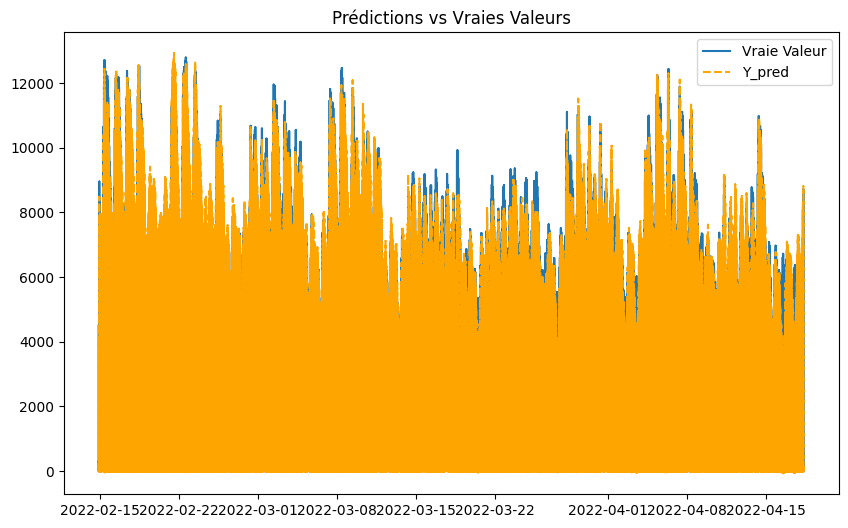

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(y_train[500040:700030].index, y_train[500040:700030], label='Vraie Valeur')
plt.plot(df_pred.index, df_pred.values, label='Y_pred', linestyle='--', color='orange')
plt.legend()
plt.title('Prédictions vs Vraies Valeurs')
plt.show()

In [93]:
X_train_lag.head()

,temperature,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,...,cos_hour,low_and_high_delta_price_mwh,target_lag_1,target_lag_2,target_lag_3,target_lag_7,target_lag_14,target_lag_20,target_lag_30,target_lag_40
datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-03,13.438379,0.0,0.378929,0.351776,0.495804,3.941953,-7.750890,209.401615,59.425209,0.0,...,1.0,0.67,20.674,1.998,215.945,25.549,0.000,0.000,0.449,0.793
2021-09-03,13.111108,0.0,0.271004,0.228546,0.380661,3.298765,-7.350743,256.857170,68.864098,0.0,...,1.0,0.67,1.969,20.674,1.998,0.000,52.001,239.541,4283.111,107.129
2021-09-03,11.285547,0.0,0.097237,0.095917,0.149811,1.860655,-3.171788,306.821615,78.557153,0.0,...,1.0,0.67,80.591,1.969,20.674,261.976,0.000,0.000,0.000,0.000
2021-09-03,10.332422,0.0,0.004967,0.007645,0.010651,2.339536,-2.933751,352.961615,87.219653,0.0,...,1.0,0.67,0.000,80.591,1.969,0.000,715.339,15.205,2.741,19.630
2021-09-03,9.718530,0.0,0.000008,0.001114,0.001114,2.644468,-2.315343,362.521615,91.119098,0.0,...,1.0,0.67,1192.050,0.000,80.591,215.945,0.000,0.001,0.107,0.977


In [83]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping


# Vérifier la disponibilité du GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Normaliser les données
#scaler = MinMaxScaler()
#X_train_lag = scaler.fit_transform(X_train_lag)

# Définir les générateurs de séquences
seq_size = length = 10
batch_size = 32  # Utiliser un batch size plus grand

train_generator = TimeseriesGenerator(X_train_lag[:500000], y_train[40:500040], stride=1, length=seq_size, batch_size=batch_size)
validate_generator = TimeseriesGenerator(X_train_lag[500000:700000], y_train[500040:700040], stride=1, length=seq_size, batch_size=batch_size)

print('Nombre d\'échantillons d\'entraînement :', len(train_generator))
print('Nombre d\'échantillons de validation :', len(validate_generator))

# Définir le modèle LSTM avec Dropout



Num GPUs Available:  1
Nombre d'échantillons d'entraînement : 15625
Nombre d'échantillons de validation : 6250


In [86]:

# Définir le callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


num_features = X_train_lag.shape[1]

model = Sequential()
model.add(LSTM(50, activation="relu", return_sequences=True, input_shape=(length, num_features)))
model.add(Dropout(rate=0.1))
model.add(LSTM(50, activation="relu"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Entraîner le modèle
history = model.fit(train_generator, verbose=2, epochs=6, validation_data=validate_generator, callbacks=[early_stopping])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 50)         │        17,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,451 (146.29 KB)

 Trainable params: 37,451 (146.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15625/15625 - 262s - 17ms/step - loss: 502146.1562 - val_loss: 306629.1562
Epoch 2/6
15625/15625 - 249s - 16ms/step - loss: 488096.0625 - val_loss: 481572.0312
Epoch 3/6
15625/15625 - 250s - 16ms/step - loss: 368335.2500 - val_loss: 280768.0000
Epoch 4/6
15625/15625 - 251s - 16ms/step - loss: 220401.3906 - val_loss: 197722.7344
Epoch 5/6
15625/15625 - 263s - 17ms/step - loss: 254161.7969 - val_loss: 210669.4688
Epoch 6/6
15625/15625 - 253s - 16ms/step - loss: 193031.2812 - val_loss: 209724.5000


In [87]:
# Prédictions
train_pred = model.predict(train_generator)
test_pred = model.predict(validate_generator)

15625/15625 ━━━━━━━━━━━━━━━━━━━━ 191s 12ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 78s 12ms/step


In [88]:
test_pred.shape, y_train.index[100040:100040+len(test_pred)].shape

((199990, 1), (199990,))

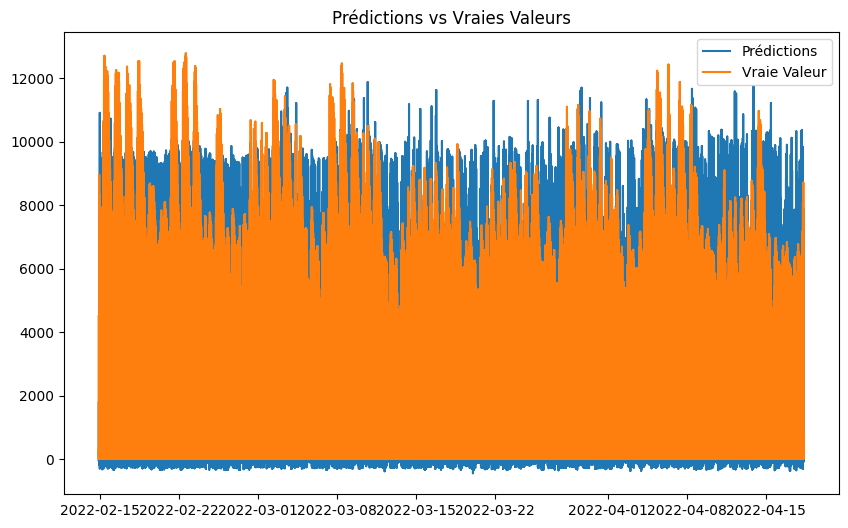

In [89]:
df_pred = pd.DataFrame(test_pred, index=y_train.index[500040:500040+len(test_pred)], columns=["y_pred"])
# Afficher les résultats
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df_pred, label='Prédictions')
plt.plot(y_train[500040:500040+len(test_pred)], label='Vraie Valeur')
plt.legend()
plt.title('Prédictions vs Vraies Valeurs')
plt.show()

In [92]:
rmse = np.sqrt(mean_squared_error(test_pred, y_train[500040:500040+len(test_pred)]))
print(f'RMSE: {rmse}')

RMSE: 1191.6462765990586


# 

# Data information

'datetime'### train.csv

- county - An ID code for the county.
- is_business - Boolean for whether or not the prosumer is a business.
- product_type - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
- target - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.
- is_consumption - Boolean for whether or not this row's target is consumption or production.
- datetime - The Estonian time in EET (UTC+2) / EEST (UTC+3). It describes the start of the 1-hour period on which target is given.
- data_block_id - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast - - weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.
- row_id - A unique identifier for the row.
- prediction_unit_id - A unique identifier for the county, is_business, and product_type combination. New prediction units can appear or disappear in the test set.
- gas_prices.csv

### gas_prices.csv

- origin_date - The date when the day-ahead prices became available.
- forecast_date - The date when the forecast prices should be relevant.
- [lowest/highest]_price_per_mwh - The lowest/highest price of natural gas that on the day ahead market that trading day, in Euros per megawatt hour equivalent.
- data_block_id
- client.csv

### client.csv

- product_type
- county - An ID code for the county. See county_id_to_name_map.json for the mapping of ID codes to county names.
- eic_count - The aggregated number of consumption points (EICs - European Identifier Code).
- installed_capacity - Installed photovoltaic solar panel capacity in kilowatts.
- is_business - Boolean for whether or not the prosumer is a business.
- date
- data_block_id
- electricity_prices.csv

### electricity_prices.csv

- origin_date
- forecast_date - Represents the start of the 1-hour period when the price is valid
- euros_per_mwh - The price of electricity on the day ahead markets in euros per megawatt hour.
- data_block_id
- forecast_weather.csv Weather forecasts that would have been available at prediction time. Sourced from the European Centre for Medium-Range Weather Forecasts.

### forecast_weather.csv

- [latitude/longitude] - The coordinates of the weather forecast.
- origin_datetime - The timestamp of when the forecast was generated.
- hours_ahead - The number of hours between the forecast generation and the forecast weather. Each forecast covers 48 hours in total.
- temperature - The air temperature at 2 meters above ground in degrees Celsius. Estimated for the end of the 1-hour period.
- dewpoint - The dew point temperature at 2 meters above ground in degrees Celsius. Estimated for the end of the 1-hour period.
- cloudcover_[low/mid/high/total] - The percentage of the sky covered by clouds in the following altitude bands: 0-2 km, 2-6, 6+, and total. Estimated for the end of the 1-hour period.
- 10_metre_[u/v]_wind_component - The [eastward/northward] component of wind speed measured 10 meters above surface in meters per second. Estimated for the end of the 1-hour period.
- data_block_id
- forecast_datetime - The timestamp of the predicted weather. Generated from origin_datetime plus hours_ahead. This represents the start of the 1-hour period for which weather data are forecasted.
- direct_solar_radiation - The direct solar radiation reaching the surface on a plane perpendicular to the direction of the Sun accumulated during the hour, in watt-hours per square meter.
- surface_solar_radiation_downwards - The solar radiation, both direct and diffuse, that reaches a horizontal plane at the surface of the Earth, accumulated during the hour, in watt-hours per square meter.
- snowfall - Snowfall over hour in units of meters of water equivalent.
- total_precipitation - The accumulated liquid, comprising rain and snow that falls on Earth's surface over the described hour, in units of meters.
- historical_weather.csv Historic weather data.

### historical_weather.csv

- datetime - This represents the start of the 1-hour period for which weather data are measured.
- temperature - Measured at the end of the 1-hour period.
- dewpoint - Measured at the end of the 1-hour period.
- rain - Different from the forecast conventions. The rain from large scale weather systems of the hour in millimeters.
- snowfall - Different from the forecast conventions. Snowfall over the hour in centimeters.
- surface_pressure - The air pressure at surface in hectopascals.
- cloudcover_[low/mid/high/total] - Different from the forecast conventions. Cloud cover at 0-3 km, 3-8, 8+, and total.
- windspeed_10m - Different from the forecast conventions. The wind speed at 10 meters above ground in meters per second.
- winddirection_10m - Different from the forecast conventions. The wind direction at 10 meters above ground in degrees.
- shortwave_radiation - Different from the forecast conventions. The global horizontal irradiation in watt-hours per square meter.
- direct_solar_radiation
- diffuse_radiation - Different from the forecast conventions. The diffuse solar irradiation in watt-hours per square meter.
- [latitude/longitude] - The coordinates of the weather station.
- data_block_id